# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Шаг 1. Открываю файл и изучаю общую информацию. 

### Импорт библиотек, загрузка и изучение данных

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

#код ниже написан для того чтобы вся таблица отображалась целиком, а то без него в середине не хватает куска)))
pd.options.display.max_columns = 100

In [91]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Строю гистограммы

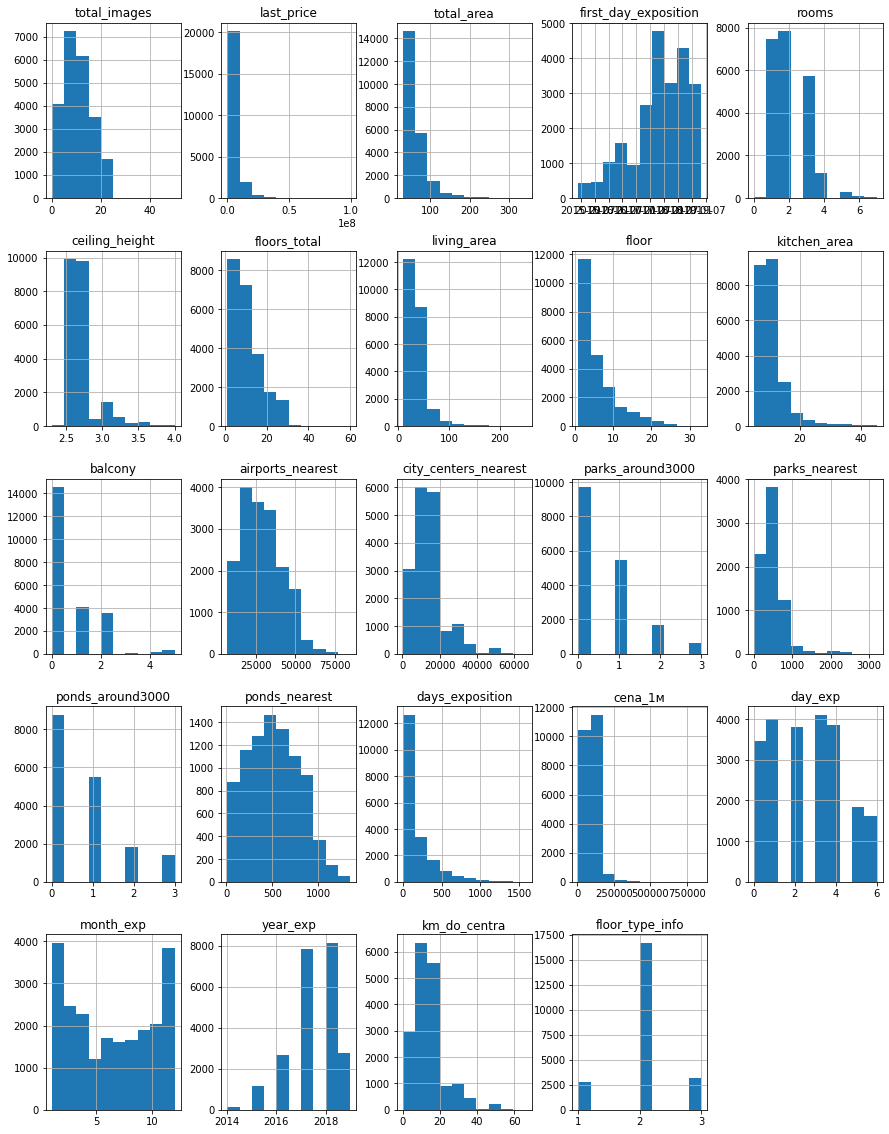

In [179]:
data.hist(figsize=(15, 20))
plt.show() #убирает текстовые предупреждения

### Вывод
Предоставленные данные представляют собой таблицу. В таблице содержится 23699 записей и 22 колонки. В качестве разделителя в csv файле используется знак табуляции (\t), вместо типичной точки с запятой. Обратим внимание, что в одной из колонок 'cityCenters_nearest' имеется не корректное название (изменим на этапе прдобработки). Ещё в таблице очень много пропусков, изучим их более детально на следующем этапе + исправим некорректный тип данных.

# Шаг 2. Предобработка данных

### Переименуем столбец

In [94]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### 1. Изучим пропущенные значения в столбцах
Как я писал выше, в таблице имеются пропуски. Попробуем их заполнить там где это возможно.

In [95]:
# Посмотрю где есть пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [96]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [97]:
import missingno as msno

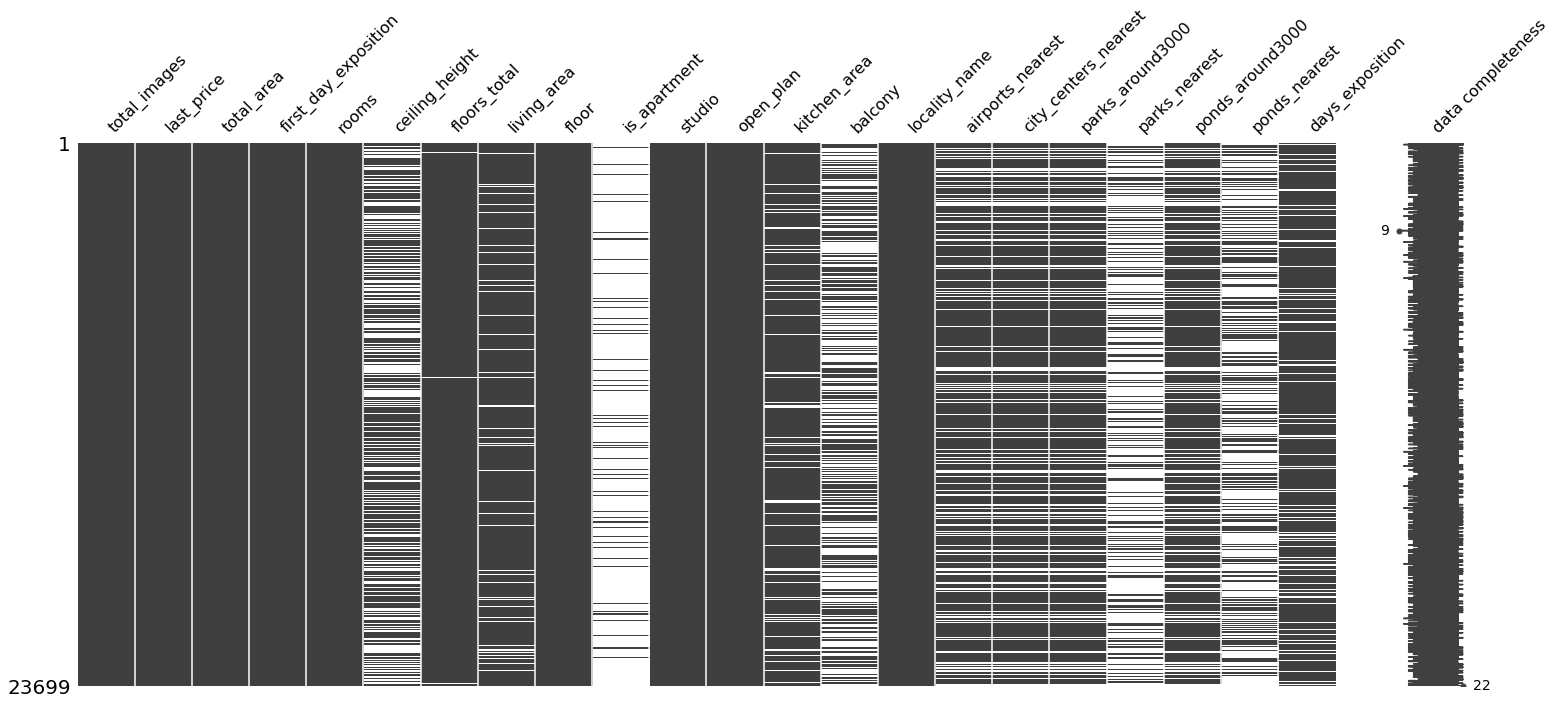

In [98]:
# Можно визуализировать пропущенные значения таким образом
msno.matrix(data, labels=True)
plt.show()

### Заполнение пропусков в столбце ceiling_height - высота потолков


Так как это проектная работа и решение проекта индивидуальный процесс, я решил разделить города на две группы Питер и НЕ Питер. Т.е. высота потолков в Питере заполнится медианным значением исключительно по Питеру (по первой группе). 
А для второй группы высота потолков заполнится медианным значением исключительно по второй группе. 
Возможно это несколько грубый метод, но повторюсь я сделал так, потому что это проект и рассчеты в данном случае у всех индивидуальны.
Для рассчёта использовал цикл. В итоге медианная высота потолков для первой группы (Питер) составила 2.70, а для второй группы 2.60.

Причины по которой данные были пропущены - это либо утеря данных при выгрузке или же данные не были внесены умышленно (допустим агентами по недвижимости, хотя это не тот показатель, который нужно скрывать, если с квартирой что-то не так). В целом точно сказать нельзя почему данные пропущены.


In [99]:
for x in data['locality_name'].unique():
    if x == 'Санкт-Петербург':
        data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == x), 'ceiling_height']  = data.loc[(data['locality_name'] == x), 'ceiling_height'].median()
    else:
        data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] != 'Санкт-Петербург'), 'ceiling_height'] = data.loc[(data['locality_name'] != 'Санкт-Петербург'), 'ceiling_height'].median()
# Проверю
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Дополнение
Можно было сделать иначе. Взять медиану по всем городам в целом и не разделять на две группы.
В таком случае медианная высота потолков составила бы 2.65 во всех пропусках.
Решение выглядело бы так:

In [100]:
#data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()
#data.head()

### Заполнение пропусков в столбце floors_total и  locality_name (высота потолков и название населённого пункта)

floors_total и locality_name имеют наименьшее кол-во пропусков (0.4% от всех) и (0.2% от всех). Процент  не большой и никак не повлияет на результат. Предлагаю удалить пропуски в floors_total, а locality_name заменить на unknown.

Причина по которой данные пропущены:

1) floors_total - могли быть пропущенны умышленно, либо случайно

2) locality_name - а вот тут странно, возможно утеря данных при выгрузке, либо так же специально, чтобы скрыть истинное расположение объекта. Теми же агентами по продажам(чтобы не спугнуть покупателя\арендатора), человек допустим видит привлекательный объект, обращает внимание где он находится и если это очень далеко, допустим, то он даже не позвонит по этому объявлению. Ну это так, мои рассуждения. На самом деле причины могут быть другими.

In [101]:
# посчитаем процент пропусков
for column in data.columns:
    empty_records = len(data.loc[data[column].isna()])
    if empty_records > 0:
        print('{} - содержит {} пропусков ({:.1%} от всех)'.format(column, empty_records, empty_records/data.shape[0]))

floors_total - содержит 86 пропусков (0.4% от всех)
living_area - содержит 1903 пропусков (8.0% от всех)
is_apartment - содержит 20924 пропусков (88.3% от всех)
kitchen_area - содержит 2278 пропусков (9.6% от всех)
balcony - содержит 11519 пропусков (48.6% от всех)
locality_name - содержит 49 пропусков (0.2% от всех)
airports_nearest - содержит 5542 пропусков (23.4% от всех)
city_centers_nearest - содержит 5519 пропусков (23.3% от всех)
parks_around3000 - содержит 5518 пропусков (23.3% от всех)
parks_nearest - содержит 15620 пропусков (65.9% от всех)
ponds_around3000 - содержит 5518 пропусков (23.3% от всех)
ponds_nearest - содержит 14589 пропусков (61.6% от всех)
days_exposition - содержит 3181 пропусков (13.4% от всех)


In [102]:
#Удаляем пропуски в floors_total
data = data.dropna(subset=['floors_total'])
data['floors_total'].isna().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               12133 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [103]:
#Меняем пропуски на unknown в locality_name
data['locality_name'] = data['locality_name'].fillna('unknowm')
data['locality_name'].isna().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               12133 non-null  float64
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

### Заполнение пропусков в столбце living_area - жилая площадь
Предполагал, что жил. площадь зависит от числа комнат. Изначально подумал заполнить пропуски медианным значением, в зависимиоти от числа комнат (получилось не очень, код закомментировал и написал почему не очень). 

В итоге решил попробовать заполнить попуски через соотношение жилой к общей.

In [104]:
#Посмотрю числовую характеристику столбца rooms, есть минимум где 0 комнат,это возможно студии или какие-то подсобные помещения(кладовки, подвалы). 
#Ещё есть помещения где аж 19 комнат. Это возможно какие-то частные дома.
data['rooms'].describe()

#Пробовал заполнить медианным значением в зависимомти от комнат, но получилось не очень.
#Т.к. появились объявления где жилая площадь больше общей, а такое не может быть.
#data.loc[data['living_area'].isna(), 'living_area'] =  data.groupby('rooms')['living_area'].median()

#Решил попробовать заполнить пропуски средним значением, через соотношение жилой к общей.
#Получилось значение: доля жилой площади к общей.
#Далее это значение умножил на общую площадь и так получилось среднее им и заполнил пропуски.
liv_tot_srednee = data['living_area'].mean() / data['total_area']

data['living_area'] = data['living_area'].fillna(liv_tot_srednee * data['total_area'])
print('Количество пропусков:', data['living_area'].isna().sum())
print()

data.info()

Количество пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               12133 non-null  float64
 14  locality_name         23613 non-null  object 

### Заполнение пропусков в столбце is_apartment - апартаменты (булев тип)
Можно предположить, что если продавцы не заполняют этот параметр, значит скорее всего их квартира - не апартаменты и они оставляют данное поле не заполненным. Поэтому все пропуски заполнил значением False.

In [105]:
data['is_apartment'] = data['is_apartment'].fillna(False)
print('Количество пропусков:',data['is_apartment'].isna().sum())
print()
data.info()

Количество пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               12133 non-null  float64
 14  locality_name         23613 non-null  object 

### Заполнение пропусков в столбце kitchen_area — площадь кухни в квадратных метрах (м²)


In [106]:
#Решил так же как и с жилой площадью попробовать заполнить пропуски средним значением, через соотношение площади кухни к общей площадти.
#Получилось значение: доля площади кухни к общей.
#Далее это значение умножил на общую площадь и так получилось среднее им и заполнил пропуски.

kitchen_area_srednee = data['kitchen_area'].mean() / data['total_area']
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_area_srednee * data['total_area'])
print('Количество пропусков:', data['kitchen_area'].isna().sum())
print()

#Посмотрим числовую характеристику по kitchen_area. Видим что есть строки где минимальная площадь чуть больше 1м², странно. Такие кухни бывают ? 
#Поищем в интернете минимальный размер кухни.Пишут, что минимум для кухни это 5м². Приложу сюда 2-е ссылки:
#1) https://apb1.ru/kuhnya-nisha.html?utm_referrer=https%3A%2F%2Fyandex.ru%2F
#2) https://stz-irk.com/minimalnaya-ploschad-kuhni-snip/
print(data['kitchen_area'].describe())
print()

#Посмотрим сколько строк менее 5м²,если их относительно мало то уберем их.
x = len(data.loc[data['kitchen_area']<5])
print('Cодержит строки где площадь кухни менее 5м² включительно ({:.2%} от всех)'.format(x/data.shape[0]));
print()

Количество пропусков: 0

count   23,613.00
mean        10.56
std          5.62
min          1.30
25%          7.30
50%         10.00
75%         11.42
max        112.00
Name: kitchen_area, dtype: float64

Cодержит строки где площадь кухни менее 5м² включительно (0.44% от всех)



In [107]:
#Уберем строки где площадь кухни менее 5м².
data = data.loc[data['kitchen_area']>=5]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23509 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23509 non-null  int64  
 1   last_price            23509 non-null  float64
 2   total_area            23509 non-null  float64
 3   first_day_exposition  23509 non-null  object 
 4   rooms                 23509 non-null  int64  
 5   ceiling_height        23509 non-null  float64
 6   floors_total          23509 non-null  float64
 7   living_area           23509 non-null  float64
 8   floor                 23509 non-null  int64  
 9   is_apartment          23509 non-null  bool   
 10  studio                23509 non-null  bool   
 11  open_plan             23509 non-null  bool   
 12  kitchen_area          23509 non-null  float64
 13  balcony               12080 non-null  float64
 14  locality_name         23509 non-null  object 
 15  airports_nearest   

### Заполнение пропусков в столбце balcony — число балконов
Можно предположить, что если продавцы не заполняют этот параметр, то балкона возможно и нет. Хотя может просто не стали указывать. В любом случае этот столбец не сильно важен. Заменим значения на 0.

In [108]:
data['balcony'] = data['balcony'].fillna(0)
print('Количество пропусков:',data['balcony'].isna().sum())

Количество пропусков: 0


### Заполнение пропусков в столбцах: 
airports_nearest,
city_centers_nearest,
parks_around3000,
parks_nearest, 
ponds_around3000,
ponds_nearest, 

Оставлю без изменений,так мы никак не можем определить, чем нам заменять пропуски, поскольку не знаем расположение квартир, а угадывать, например, по населённому пункту - это искажать данные, поскольку если попробовать в Питере заполнять пропуски расстояния до аэропорта по среднему или медиане, то получится сильно не достоверно, поскольку Питер большой и расстояние до аэропорта по разным районам может быть очень разным.

In [109]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5497
city_centers_nearest     5474
parks_around3000         5473
parks_nearest           15484
ponds_around3000         5473
ponds_nearest           14486
days_exposition          3158
dtype: int64

### Заполнение пропусков в  столбце days_exposition - сколько дней было размещено объявление (от публикации до снятия)

days_exposition - содержит 3181 пропусков (13.4% от всех). Как вариант, можно было бы заполнить средним значением в зависимости от количества комнат в квартире, но я думаю тут не совсем корректно, т.к. каждый объект недвижимости очень индивидуален и на продажу влияет очень много факторов. Возможно здесь ошибка при выгрузке произошла и данные не подгрузились. Может стоит сделать баг-репорт и чтобы коллеги поправили, вдруг данные на самом деле там есть.

Пример того, как можно было заполнить закомментиовал (на примере, если в квартире 3 комнаты).

*Баг-репорт - это отчет/документ, в котором подробно излагаются проблемы с программным обеспечением, устройством или процессом. По-другому его называют отчет об ошибке. Он помогает производителям и разработчикам отслеживать, определять приоритеты и устранять проблемы в существующем программном обеспечении или продуктах.

In [110]:
#for x in data['rooms'].unique():
    #if x == 3:
        #data.loc[(data['days_exposition'].isna()) & (data['rooms']==x),'days_exposition'] = data.loc[(data['rooms']==x), 'days_exposition'].mean()
#data.head()        

### 2. Рассмотрим типы данных в каждом столбце и поменяем там где это возможно

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23509 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23509 non-null  int64  
 1   last_price            23509 non-null  float64
 2   total_area            23509 non-null  float64
 3   first_day_exposition  23509 non-null  object 
 4   rooms                 23509 non-null  int64  
 5   ceiling_height        23509 non-null  float64
 6   floors_total          23509 non-null  float64
 7   living_area           23509 non-null  float64
 8   floor                 23509 non-null  int64  
 9   is_apartment          23509 non-null  bool   
 10  studio                23509 non-null  bool   
 11  open_plan             23509 non-null  bool   
 12  kitchen_area          23509 non-null  float64
 13  balcony               23509 non-null  float64
 14  locality_name         23509 non-null  object 
 15  airports_nearest   

In [112]:
# Приводим в целочисленный тип стоимость квартиры для более удобного восприятия
data['last_price'] = data['last_price'].astype(int)
# Приводим содержимое этого столбца в понятные для Python даты. Т.к. сейчас там  тип строка (object)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
# Приводим в целочисленный тип этажи в доме для более удобного восприятия
data['floors_total'] = data['floors_total'].astype(int)
# Приводим в целочисленный тип количество балконов для более удобного восприятия
data['balcony'] = data['balcony'].astype(int)

### 3. Изучим уникальные значения в столбце с названиями и устраним  неявные дубликаты

Приведём всё к нижнему регистру, заменим все 'ё' на 'е', изменим названия "городской поселок" на "поселок городского типа"


In [113]:
#Напишем функцию для подсчёта уникальных значений
def unikalnie():
    return print('Количество уникальных занчений locality_name:', data['locality_name'].unique().shape[0])
unikalnie()
print()
print('Количетво явных дубликатов:', data.duplicated().sum())
print()
print(data['locality_name'].unique())

Количество уникальных занчений locality_name: 364

Количетво явных дубликатов: 0

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Му

In [114]:
#Приводим всё к нижнему регистру на всякий случай
data['locality_name'] = data['locality_name'].str.lower()

#Заменим все 'ё' на 'е'
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

#Изменим названия "городской поселок" на "поселок городского типа"
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')

unikalnie()

print('Количетво явных дубликатов:', data.duplicated().sum())
print('Количество уникальных занчений locality_name сократили на 41, было 347, стало 306')





Количество уникальных занчений locality_name: 323
Количетво явных дубликатов: 0
Количество уникальных занчений locality_name сократили на 41, было 347, стало 306


### 4. Найдём и устраним редкие и выбивающиеся значения

### Столбец last_price — цена на момент снятия с публикации

In [115]:
print('Минимальная стоимость объекта:', min(data['last_price']))
print('Максимальная стоимость объекта:',max(data['last_price']))

Минимальная стоимость объекта: 12190
Максимальная стоимость объекта: 763000000


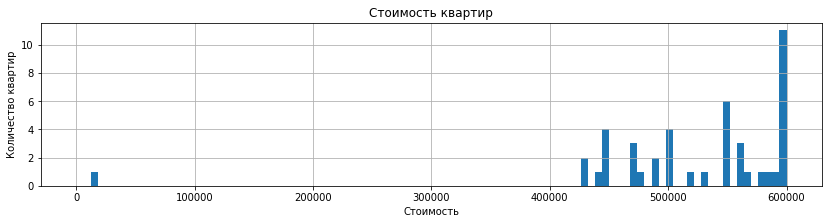

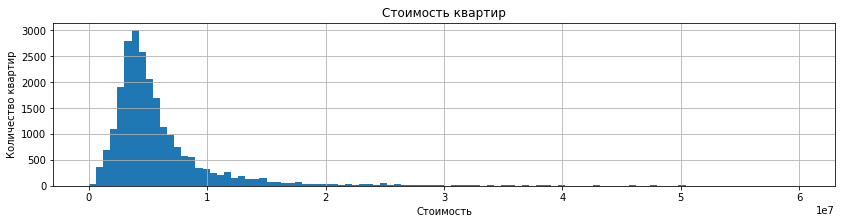

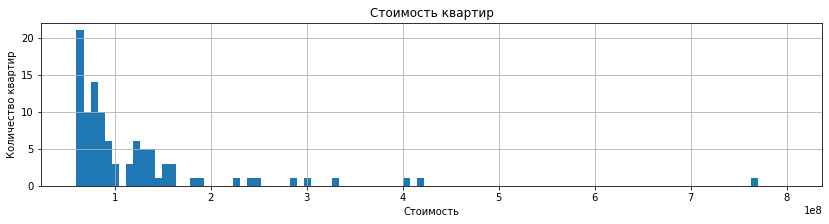

In [116]:
# Посмотрим стоимость квартир
data.hist('last_price', bins=100, figsize=(14,3), range=(0, 600001))
plt.title('Стоимость квартир')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()
data.hist('last_price', bins=100, figsize=(14,3), range=(0, 60000001))
plt.title('Стоимость квартир')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()
data.hist('last_price', bins=100, figsize=(14,3), range=(60000000, 800000000))
plt.title('Стоимость квартир')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()

In [117]:
#Есть выбросы, посмотрим сколько их и если их не так много то избавимся от них.
#Основная масса сосредоточена от 400 тыс до 100 млн. руб.
print('Количество выбросов:', len(data.query('last_price < 400000')) + len(data.query('last_price > 100000000')))
print()
#Выбросов не много, можем их убрать
data = data.query('last_price > 400000 and last_price < 100000000')

Количество выбросов: 38



### Столбец total_area — общая площадь квартиры в квадратных метрах (м²)

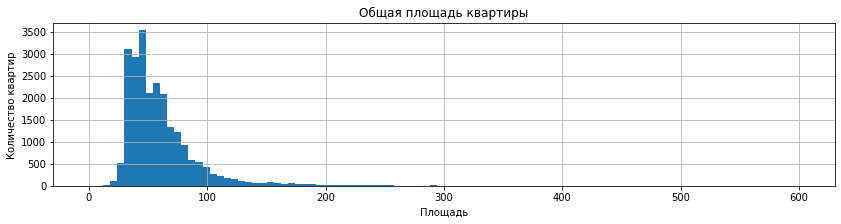

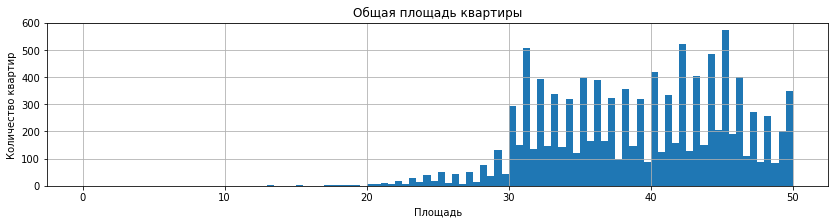

In [118]:
# Посмотрим общую площадь
data.hist('total_area', bins=100, figsize=(14,3), range=(0, 600))
plt.title('Общая площадь квартиры')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()
#Посмотрим поближе
data.hist('total_area', bins=100, figsize=(14,3), range=(0, 50))
plt.title('Общая площадь квартиры')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()

In [119]:
#Думаю можно оставить всё что выше 30м², изучим информацию в интернете про общую площадь(комментарий ниже)

### Посмотрим что у нас в диапазоне от 200м² до 600м²

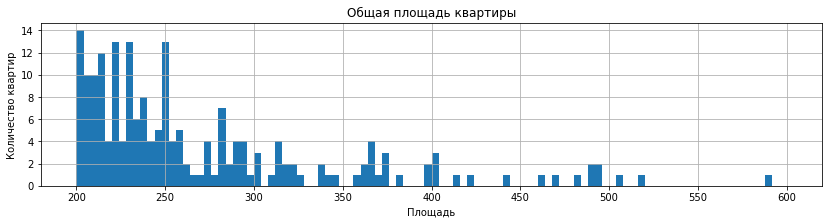

In [120]:
data.hist('total_area', bins=100, figsize=(14,3), range=(200, 600))
plt.title('Общая площадь квартиры')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()
#До 350м² всё распределяется более менее равномерно, всё что выше 350м² уберем.

In [121]:
#Есть выбросы, посмотрим сколько их и если их не так много то избавимся от них.
#Посмотрим в интернете информацию о норме общей площади, на двух разных сайтах пишут:
#1) https://blog.domclick.ru/nedvizhimost/post/skolko-kvadratnyh-metrov-polozheno-na-cheloveka-v-kvartire
#"Нормы для семей и одиноких людей разные. Норматив однокомнатной квартиры для одного человека — 33-34 кв. м".
#2) https://j.etagi.com/ps/norma-ploshchadi-na-1-cheloveka-v-kvartire/
#"Cтaндapтными pacчeтaми coциaльнoгo нopмaтивa cчитaютcя 33 кв.м. нa 1 oднoгo".
#Оставим всё что в этом диапазоне от 30м² до 350м², остальное удалим.

print('Количество выбросов:', len(data.query('total_area < 30')) + len(data.query('total_area > 350')))
print()
#Выбросов не много, можем их убрать
data= data.query('total_area >= 30 and total_area < 350')

Количество выбросов: 672



In [122]:
#Использую функцию round() для округления
print('Процент оставшихся данных:', (round(22670 / 23699, 4)*100), '%')

Процент оставшихся данных: 95.66 %


### Столбец rooms — комнаты

In [123]:
#Посмотрим комнаты
print(data['rooms'].value_counts())

2     7867
1     7485
3     5777
4     1165
5      309
6       96
7       44
0       34
8        9
9        6
10       3
11       2
16       1
14       1
Name: rooms, dtype: int64


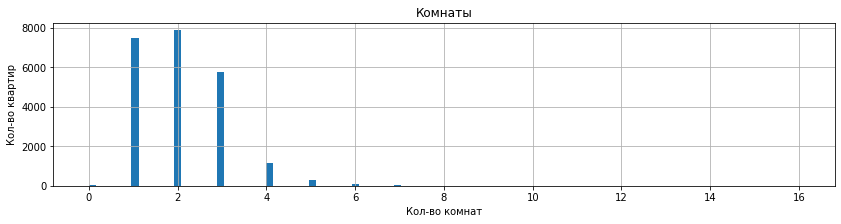

In [124]:
data.hist('rooms', bins=100, figsize=(14,3), range=(0, 16))
plt.title('Комнаты')
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во квартир')
plt.show()

### Посмотрим поближе в диапазоне от 7 и выше

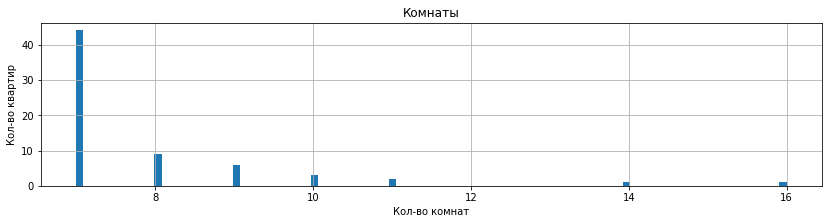

Количество выбросов: 22


In [125]:
#Есть выбросы начиная от 8 комнат и выше.
data.hist('rooms', bins=100, figsize=(14,3), range=(7, 16))
plt.title('Комнаты')
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во квартир')
plt.show()
#Посмотрим сколько их.
print('Количество выбросов:', len(data.query('rooms >= 8')))
##Выбросов не много, можем их убрать
data = data.query('rooms <= 7')

In [126]:
#Есть 34 квартиты где 0 комнат, в основном это студии.
display(data.query('rooms == 0'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
508,0,3375000,34.40,2017-03-28,0,2.60,26,24.30,19,False,False,True,10.56,1,поселок парголово,"53,115.00","19,292.00",0.00,NaN,1.00,593.00,430.00
839,14,1900000,35.00,2017-04-14,0,2.70,5,15.00,3,False,False,True,10.56,1,поселок новый свет,NaN,NaN,NaN,NaN,NaN,NaN,7.00
1174,3,3900000,32.00,2016-10-18,0,2.70,24,18.00,2,False,True,False,10.56,2,санкт-петербург,"44,754.00","8,409.00",1.00,609.00,0.00,NaN,540.00
1528,8,1950000,31.00,2019-01-29,0,2.60,18,18.00,11,False,True,False,10.56,2,никольское,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1600,11,2550000,30.00,2017-11-10,0,2.75,23,15.90,11,False,True,False,10.56,2,санкт-петербург,"21,928.00","17,256.00",0.00,NaN,1.00,429.00,19.00
3147,7,2170000,31.00,2017-12-30,0,2.60,12,34.46,12,False,True,False,10.56,0,тосно,NaN,NaN,NaN,NaN,NaN,NaN,198.00
3458,6,7400000,73.60,2017-05-18,0,2.70,3,50.00,1,False,True,False,10.56,0,санкт-петербург,"26,581.00","6,085.00",0.00,NaN,1.00,348.00,60.00
4683,2,3650000,35.00,2018-02-01,0,2.70,25,23.40,25,False,False,True,10.56,0,санкт-петербург,"43,431.00","12,188.00",0.00,NaN,0.00,NaN,100.00
6220,0,1100000,32.00,2018-03-06,0,2.70,3,20.00,1,False,True,False,10.56,0,поселок городского типа большая ижора,NaN,NaN,NaN,NaN,NaN,NaN,70.00
6805,7,1850000,31.00,2017-11-10,0,2.60,18,18.00,10,False,False,True,10.56,1,никольское,NaN,NaN,NaN,NaN,NaN,NaN,7.00


In [127]:
#Посмотрим значения площадей квартир в этих строках, медиана (32м²) и среднее(38м²) не сильно отличаются.
#Скорее всего это однокомнатные.
print(data.query('rooms == 0')['total_area'].describe())
print()
#Заменим значение 0 комнат на 1 комната там, где квартира не является студией(studio).
print('Было квартир с количеством комнат 0:', len(data.loc[data['rooms']==0]))
data.loc[(data['rooms']==0) & (data['studio']==False), 'rooms'] = 1
print('Стало квартир с количеством комнат 0:', len(data.loc[data['rooms']==0]))

count   34.00
mean    38.45
std     15.11
min     30.00
25%     31.00
50%     32.25
75%     37.47
max     98.40
Name: total_area, dtype: float64

Было квартир с количеством комнат 0: 34
Стало квартир с количеством комнат 0: 24


### Столбец ceiling_height - высота потолков (м)

In [128]:
#Посмотрим высоту потолков
data['ceiling_height'].describe()

count   22,777.00
mean         2.72
std          0.76
min          1.00
25%          2.60
50%          2.70
75%          2.70
max         32.00
Name: ceiling_height, dtype: float64

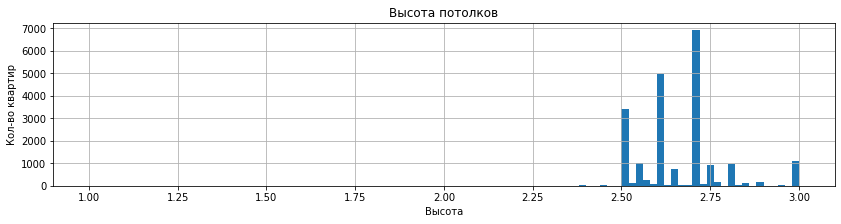

In [129]:
#Есть выбросы, минимум 1 метр/макисмум 32 метра.
data.hist('ceiling_height', bins=100, figsize=(14,3), range=(1, 3))
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Кол-во квартир')
plt.show()
#Поищем информацию в интернете:
#1) http://expert-home.net/standartnaya-vysota-potolkov-v-kvartire/:
#Стандартная высота потолков в квартире – от 2.50 м до 2.70 м.

### Посмотрим поближе в диапазоне от 5 и выше

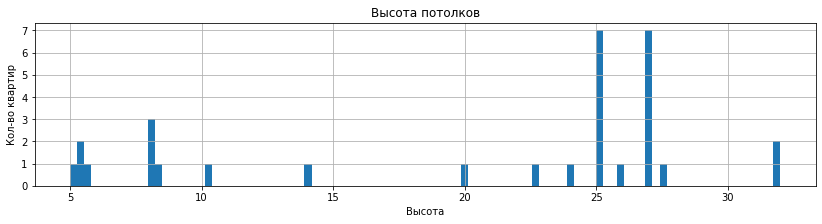

In [130]:
data.hist('ceiling_height', bins=100, figsize=(14,3), range=(5, 32))
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Кол-во квартир')
plt.show()

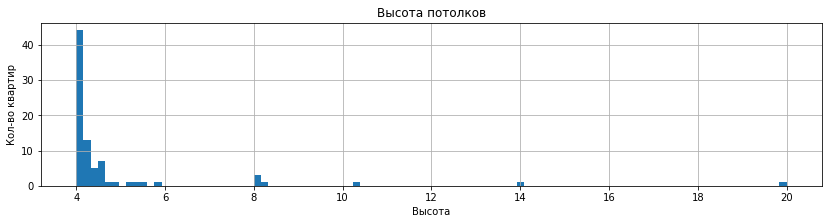

Количество выбросов: 60


In [131]:
#Исправим все значения выше 23 чтобы не терять данные, +- 20 сантиметров роли не сыграет.
#Вероятнее всего в значениях пропущена запятая, исправим там где это возможно разделив на 10.
data.loc[data['ceiling_height'] >= 23,'ceiling_height'] /= 10
#Посмотрим что у нас выше 4 метров
data.hist('ceiling_height', bins=100, figsize=(14,3), range=(4, 20))
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Кол-во квартир')
plt.show()
#Посмотрим сколько квартир с высотой потолков ниже 2.3 и выше 4 метров.
print('Количество выбросов:', len(data.query('ceiling_height < 2.3')) + len(data.query('ceiling_height > 4')))
##Выбросов не много, можем их убрать
data = data.query('ceiling_height >= 2.3 and ceiling_height <=4')

### Столбец living_area - жилая площадь в квадратных метрах (м²)

In [132]:
#Посмотрим жилую площадь
data['living_area'].describe()

count   22,717.00
mean        34.41
std         18.76
min          2.00
25%         20.00
50%         31.50
75%         41.70
max        255.70
Name: living_area, dtype: float64

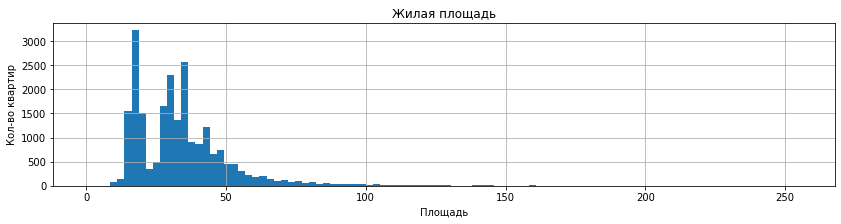

In [133]:
#Есть выбросы, минимум 2м².
data.hist('living_area', bins=100, figsize=(14,3), range=(1, 255))
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Кол-во квартир')
plt.show()
#Поищем информацию в интернете:
#1) https://gu.spb.ru/help/usefulinfo/Socialnyj-naem/
#Учетная норма — минимальный размер площади жилого помещения на человека, 
#в Санкт-Петербурге действуют следующие учетные нормы:
#9м2 общей площади жилого помещения для проживающих в отдельных квартирах и жилых домах.

### Посмотрим поближе

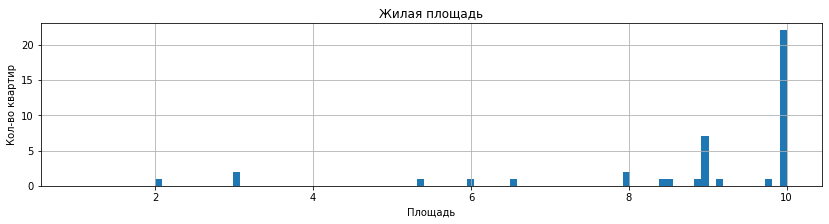

Количество выбросов: 11


In [134]:
data.hist('living_area', bins=100, figsize=(14,3), range=(1, 10))
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Кол-во квартир')
plt.show()
#Посмотрим сколько квартир с жил. площадью меньше 9м2.
print('Количество выбросов:', len(data.query('living_area < 9')))
#Выбросов не много, можем их убрать
data = data.query('living_area >= 9')

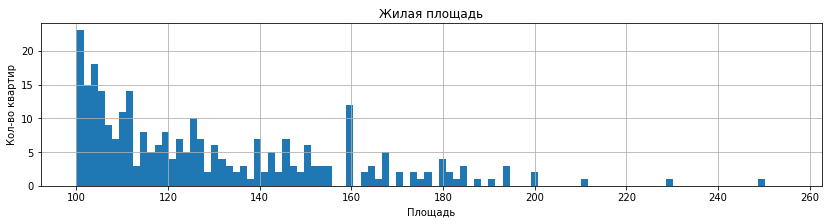

In [135]:
data.hist('living_area', bins=100, figsize=(14,3), range=(100, 255))
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Кол-во квартир')
plt.show()
#Тут распределение равномерное, не буду трогать.Большая площадь может быть в частных домах к примеру.

### Столбец kitchen_area - площадь кухни в квадратных метрах (м²)

In [136]:
#Посмотрим площадь кухни.
data['kitchen_area'].describe()

count   22,706.00
mean        10.56
std          5.39
min          5.00
25%          7.50
50%         10.00
75%         11.50
max        107.00
Name: kitchen_area, dtype: float64

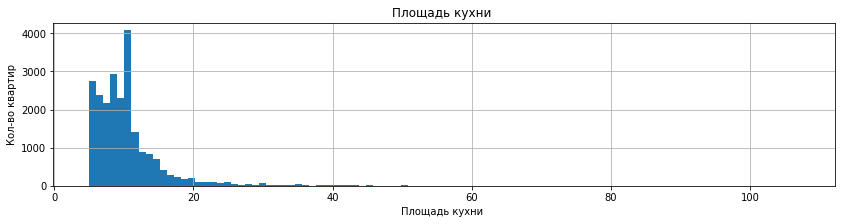

In [137]:
#Есть выбросы максисмум 107м².
data.hist('kitchen_area', bins=100, figsize=(14,3), range=(5, 107))
plt.title('Площадь кухни ')
plt.xlabel('Площадь кухни ')
plt.ylabel('Кол-во квартир')
plt.show()
#Поищем информацию в интернете:
#1) https://akb-project.ru/razmer-pomeshenij - тут пишу минимум 5м²
#2) https://gsps.ru/poleznoe/minimalnaya-ploshchad-pomeshcheniy-kvartiry.php#Минимальные_площади_помещений_квартиры - тут 6м²
#у нас так и получается минимум 5м².

### Посмотрим поближе от 20 и выше

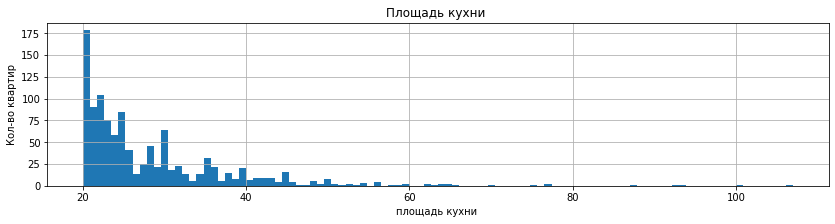

In [138]:
data.hist('kitchen_area', bins=100, figsize=(14,3), range=(20, 107))
plt.title('Площадь кухни ')
plt.xlabel('площадь кухни ')
plt.ylabel('Кол-во квартир')
plt.show()

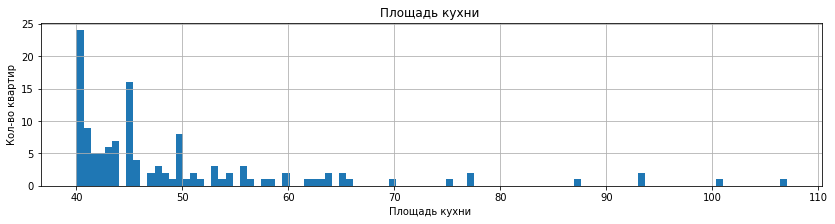

In [139]:
data.hist('kitchen_area', bins=100, figsize=(14,3), range=(40, 107))
plt.title('Площадь кухни ')
plt.xlabel('Площадь кухни ')
plt.ylabel('Кол-во квартир')
plt.show()

In [140]:
#Посмотрим сколько квартир с площадью кухни более 40м2.
print('Количество квартир с площадью кухни более 40м2:', len(data.query('kitchen_area > 40')))
display(data.query('kitchen_area > 40').head())
#Заметил что в некоторых столбцах площадь кукхни больше жилой площади

Количество квартир с площадью кухни более 40м2: 109


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,санкт-петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00
51,7,45000000,161.00,2017-10-17,3,3.20,8,38.00,4,False,False,False,50.00,0,санкт-петербург,"32,537.00","6,589.00",0.00,NaN,3.00,99.00,541.00
263,12,39900000,140.60,2016-11-19,2,3.50,8,39.80,7,False,False,False,49.20,4,санкт-петербург,"32,537.00","6,589.00",0.00,NaN,3.00,99.00,NaN
492,18,95000000,216.00,2017-12-05,4,3.00,5,86.00,4,False,False,False,77.00,0,санкт-петербург,"21,740.00",436.00,2.00,138.00,3.00,620.00,14.00
511,7,5950000,69.00,2017-12-21,1,2.60,16,13.00,12,False,False,False,50.00,1,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,56.00


In [141]:
print('Кол-во строк где кухня больше жилой:', len(data.query('kitchen_area > living_area')))

Кол-во строк где кухня больше жилой: 358


In [142]:
#Поменяем местами значения.
#Формируем временный столбец со значениями из living_area.
data['living_area_2'] = data['living_area']

#Заменим некорректные значения в living_area данными из kitchen_area.
data.loc[(data['kitchen_area'] > data['living_area']), 'living_area'] = \
data.loc[(data['kitchen_area'] > data['living_area']), 'kitchen_area']

#А теперь - значения в kitchen_area заменим заранее сохранёнными данными из living_area_2.
#Для всех тех строк, где площади жилая и кухни равны 
#(то есть мы меняли на предыдущем этапе размеры жилой площади) - внесём в ячейки с 
#площадью кухни  - размер жилой площади из временного столбца
data.loc[(data['kitchen_area'] - data['living_area'] ==0), 'kitchen_area'] = \
data.loc[(data['kitchen_area'] - data['living_area'] ==0), 'living_area_2']

#Удалим временный столбец
data = data.drop(columns='living_area_2')


In [143]:
#Проверим
print('Кол-во строк где кухня больше жилой:', len(data.query('kitchen_area > living_area')))

Кол-во строк где кухня больше жилой: 0


count   22,706.00
mean        10.45
std          5.03
min          5.00
25%          7.50
50%         10.00
75%         11.50
max        100.70
Name: kitchen_area, dtype: float64


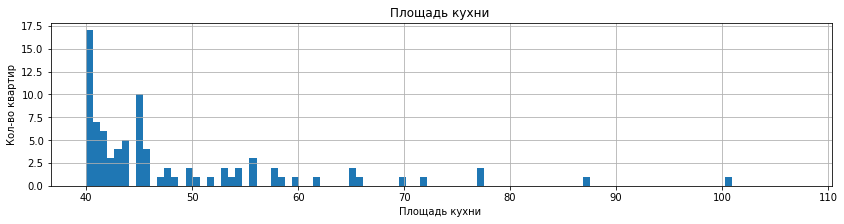

In [144]:
#Посмотрим ещё раз площадь кухни.
print(data['kitchen_area'].describe())
#Теперь выбросы максисмум 100м².
data.hist('kitchen_area', bins=100, figsize=(14,3), range=(40, 107))
plt.title('Площадь кухни ')
plt.xlabel('Площадь кухни ')
plt.ylabel('Кол-во квартир')
plt.show()

In [145]:
print('Количество квартир с площадью кухни более 40м2:', len(data.query('kitchen_area > 40')), 'а было 109')

Количество квартир с площадью кухни более 40м2: 72 а было 109


In [146]:
#Теперь посмотрим что с кухнями площадью более 45 квадратов, т.к. до 45 квадратов боле менее равномерно всё.
print('Количество выбросов:', len(data.query('kitchen_area > 45')))
#Выбросов не много, можем их убрать
data = data.query('kitchen_area <= 45')

Количество выбросов: 35


### Вывод
Всего было строк: 23699, после обработки стало: 22671, получается удалили 4,33%.

В стлобце ceiling_height пропуски заменены медианными значениями, а так исправлены ошибочно введенные значения, в которых справа присутствовал лишний ноль.

Столбец first_day_exposition привели к корректному типу datetime64.

В столбцах living_area и kitchen_area пропуски заменены средними значениями в зависимости от отношения к общей площади.
Ещё в столбце kitchen_area были обнаружены значения площади превышающие значения жилой площади. Поменяли их местами, считаю тем самым сохранили какую-то часть данных, вместо того чтобы их удалять.

В числовых столбцах заменены типы на int, кроме столбцов с площадями.

В столбце days_exposition пропуски не заполнял(комментарий указан выше).

Обрезаны сильные выбросы в столбцах где они были.

В столбцах с расстояниями пропуски не заменял(комментарий указан выше).

# Шаг 3. Добавим в таблицу новые столбцы.

### Посчитаем и добавим столбец: цена одного квадратного метра.

In [147]:
data['cena_1м'] = data['last_price']/data['total_area']
#Поменяем тип на int
data['cena_1м'] = data['cena_1м'].astype(int)
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cena_1м
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,санкт-петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,120370
1,7,3350000,40.40,2018-12-04,1,2.60,11,18.60,1,False,False,False,11.00,2,поселок шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,82920
2,10,5196000,56.00,2015-08-20,2,2.70,5,34.30,4,False,False,False,8.30,0,санкт-петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,92785
3,0,64900000,159.00,2015-07-24,3,2.70,14,34.46,9,False,False,False,10.56,0,санкт-петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,408176
4,2,10000000,100.00,2018-06-19,2,3.03,14,41.00,13,False,False,False,32.00,0,санкт-петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,100000


### Посчитаем и добавим столбец: день недели публикации объявления (0 — понедельник, 1 — вторник и так далее), месяц публикации объявления, год публикации объявления.

In [148]:
data['day_exp'] = data['first_day_exposition'].dt.weekday
data['month_exp'] = data['first_day_exposition'].dt.month
data['year_exp'] = data['first_day_exposition'].dt.year
display(data[['day_exp', 'first_day_exposition', 'month_exp', 'year_exp']].head())

,day_exp,first_day_exposition,month_exp,year_exp
0,3,2019-03-07,3,2019
1,1,2018-12-04,12,2018
2,3,2015-08-20,8,2015
3,4,2015-07-24,7,2015
4,1,2018-06-19,6,2018


### Посчитаем и добавим столбец: тип этажа квартиры (значения — «первый», «последний», «другой»).

In [149]:
#Создадим функцию для столбца с типом этажа.
def floor_type(row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    else:
        return 'Другой'
data['floor_type'] = data.apply(floor_type, axis=1)
display(data.head())
print(data['floor_type'].value_counts())
        

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cena_1м,day_exp,month_exp,year_exp,floor_type
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,санкт-петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,120370,3,3,2019,Другой
1,7,3350000,40.40,2018-12-04,1,2.60,11,18.60,1,False,False,False,11.00,2,поселок шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,82920,1,12,2018,Первый
2,10,5196000,56.00,2015-08-20,2,2.70,5,34.30,4,False,False,False,8.30,0,санкт-петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,92785,3,8,2015,Другой
3,0,64900000,159.00,2015-07-24,3,2.70,14,34.46,9,False,False,False,10.56,0,санкт-петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,408176,4,7,2015,Другой
4,2,10000000,100.00,2018-06-19,2,3.03,14,41.00,13,False,False,False,32.00,0,санкт-петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,100000,1,6,2018,Другой


Другой       16708
Последний     3187
Первый        2776
Name: floor_type, dtype: int64


### Посчитаем и добавим столбец: расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [150]:
data['km_do_centra'] = (data['city_centers_nearest'] / 1000)
data['km_do_centra'] = round(data['km_do_centra'], 0)
display(data[['km_do_centra', 'city_centers_nearest']].head())

,km_do_centra,city_centers_nearest
0,16.00,"16,028.00"
1,19.00,"18,603.00"
2,14.00,"13,933.00"
3,7.00,"6,800.00"
4,8.00,"8,098.00"


# Шаг 4. Проведём исследовательский анализ данных.

### 1. Изучите следующие параметры объектов

### Общая площадь

count   22,671.00
mean        60.05
std         29.52
min         30.00
25%         41.00
50%         53.00
75%         70.00
max        342.00
Name: total_area, dtype: float64


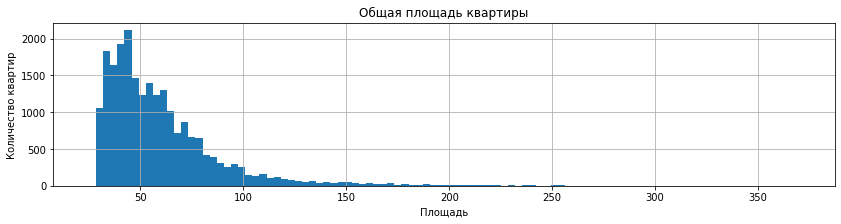

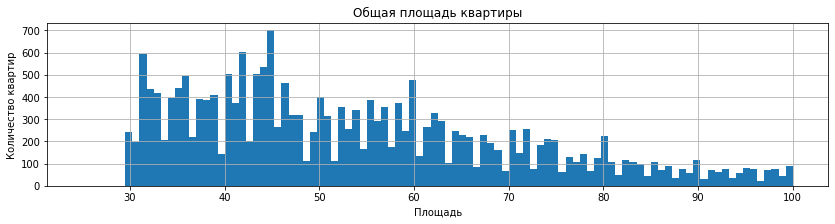

In [151]:
#Посмотрим общую площадь
print(data['total_area'].describe())

data.hist('total_area', bins=100, figsize=(14,3), range=(25, 370))
plt.title('Общая площадь квартиры')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()
print()
data.hist('total_area', bins=100, figsize=(14,3), range=(25, 100))
plt.title('Общая площадь квартиры')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()

##### По гистограмме видно, что основная масса квартир с площадями от 30м² до 45м² и вероятнее всего это однокомнатные квартиры. Далее идут 2-ки, 3-ки. в диапазоне от 45м² и 75-80м². После скорее всего идут 4-х комнатные и более. Видно, что с увеличенем площади уменьшается количество квартир. Напоминает распределение Пуассона.

### Жилая площадь

count   22,671.00
mean        34.44
std         18.54
min          9.00
25%         20.00
50%         31.60
75%         41.70
max        250.00
Name: living_area, dtype: float64


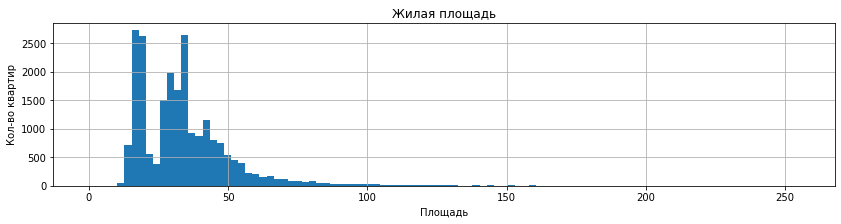

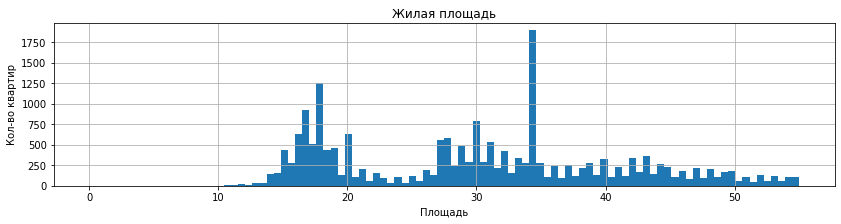

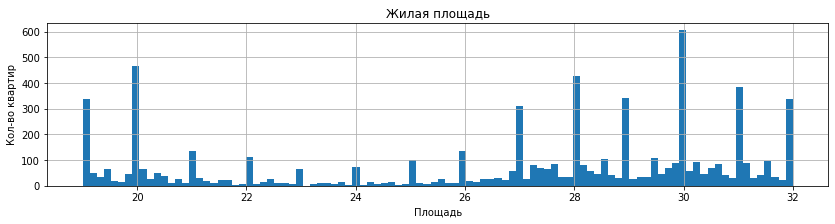

In [152]:
#Посмотрим жилую площадь
print(data['living_area'].describe())

data.hist('living_area', bins=100, figsize=(14,3), range=(0, 255))
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Кол-во квартир')
plt.show()
print()
data.hist('living_area', bins=100, figsize=(14,3), range=(0, 55))
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Кол-во квартир')
plt.show()
print()
data.hist('living_area', bins=100, figsize=(14, 3), range=(19, 32))
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Кол-во квартир')
plt.show()

##### По гистограмме видно, что основная масса квартир с жилой площадью сосредоточена  в районе 18м², 30м² и 34м².  Ещё можно заметить провал в значениях жилой площа в диапазоне от 20м² до 26м². Возможно это связано с самим городом в целом. Я имею виду, если сравнивать Москву и Питер. Всё равно это разные города и возможно строили там в своё время по разному, может с этим и связан провал в указанном диапазоне.

### Площадь кухни

count   22,671.00
mean        10.38
std          4.64
min          5.00
25%          7.50
50%         10.00
75%         11.50
max         45.00
Name: kitchen_area, dtype: float64


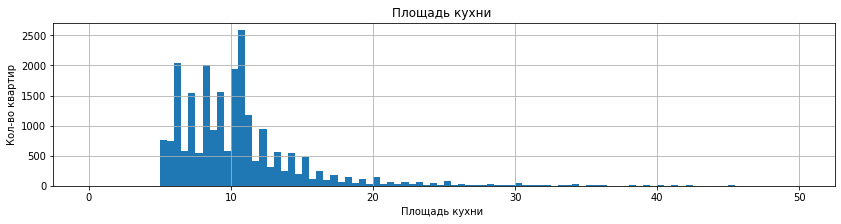

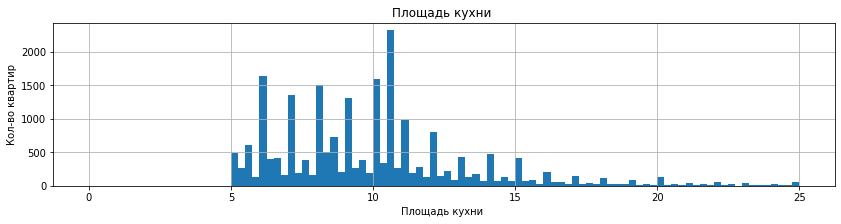

In [153]:
#Посмотрим площадь кухни
print(data['kitchen_area'].describe())

data.hist('kitchen_area', bins=100, figsize=(14,3), range=(0, 50))
plt.title('Площадь кухни ')
plt.xlabel('Площадь кухни ')
plt.ylabel('Кол-во квартир')
plt.show()
print()
data.hist('kitchen_area', bins=100, figsize=(14,3), range=(0, 25))
plt.title('Площадь кухни ')
plt.xlabel('Площадь кухни ')
plt.ylabel('Кол-во квартир')
plt.show()

##### Диапазон площади кухни  распределился в основном от 5м² до 15м², а в среднем 10м². Тут всё  нормально, плавное распределение и опять по мере увеличения площади, идёт уменьшение квартир.

### Цена объекта

count       22,671.00
mean     6,214,407.18
std      5,932,366.52
min        430,000.00
25%      3,500,000.00
50%      4,700,000.00
75%      6,800,000.00
max     99,000,000.00
Name: last_price, dtype: float64


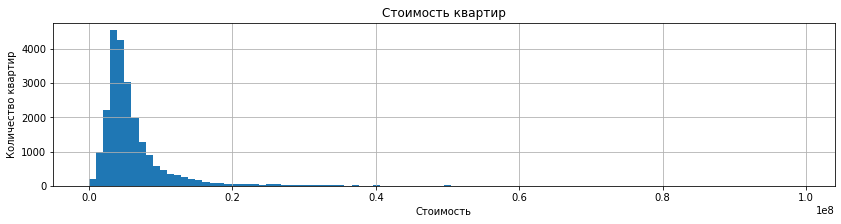

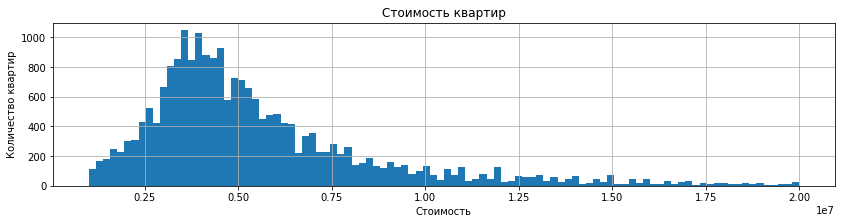

In [154]:
# Посмотрим стоимость квартир
print(data['last_price'].describe())

data.hist('last_price', bins=100, figsize=(14,3), range=(0, 99000000))
plt.title('Стоимость квартир')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()
print()
data.hist('last_price', bins=100, figsize=(14,3), range=(1000000, 20000000))
plt.title('Стоимость квартир')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()



##### 

##### Гистограмма показывает, что в основном квартиры продаются от 2,5 млн до примерно 5,5 млн. Далее же с увеличением числа стоимости объекта, уменьшается кол-во таких объектов.

### Количество комнат

count   22,671.00
mean         2.09
std          1.01
min          0.00
25%          1.00
50%          2.00
75%          3.00
max          7.00
Name: rooms, dtype: float64

2    7850
1    7473
3    5738
4    1150
5     302
6      93
7      42
0      23
Name: rooms, dtype: int64


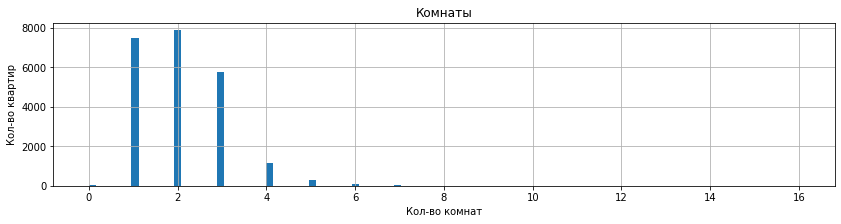

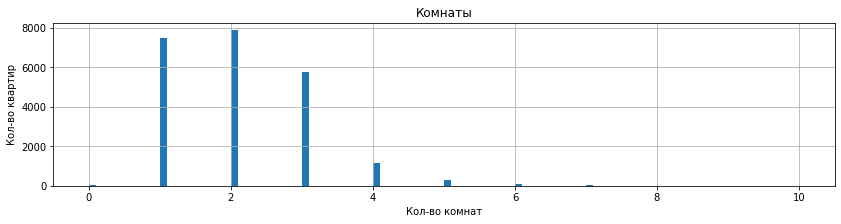

In [155]:
#Посмотрим комнаты
print(data['rooms'].describe())
print()
print(data['rooms'].value_counts())

data.hist('rooms', bins=100, figsize=(14,3), range=(0, 16))
plt.title('Комнаты')
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('rooms', bins=100, figsize=(14,3), range=(0, 10))
plt.title('Комнаты')
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во квартир')
plt.show()

##### Всё ведёт к тому, что в основном преобладают 1-ки и 2-ки. Трёхкомнатные тоже предпочитают, вероятнее всего люди у которых большая семья. С 4-х комнатными тоже самое, но их очень мало, как и квартир в которых комнат от 4-х и выше.


### Высота потолков

count   22,671.00
mean         2.70
std          0.20
min          2.30
25%          2.60
50%          2.70
75%          2.70
max          4.00
Name: ceiling_height, dtype: float64


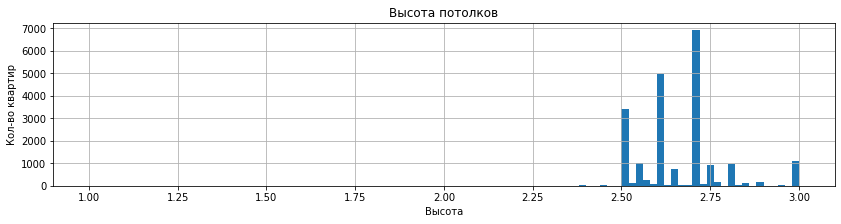

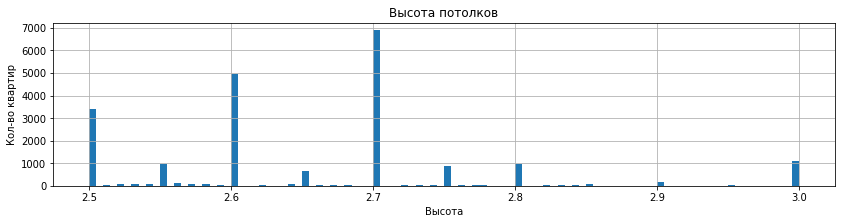

In [156]:
#Посмотрим высоту потолков
print(data['ceiling_height'].describe())

data.hist('ceiling_height', bins=100, figsize=(14, 3), range=(1, 3))
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Кол-во квартир')
plt.show()



data.hist('ceiling_height', bins=100, figsize=(14,3), range=(2.5, 3))
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Кол-во квартир')
plt.show()

##### С высотой потолков тоже всё в порядке, есть как минимальные значения 2.30м(возможно это какие не супер новые дома) так и немного выбивающиеся из нормы от 2.75м до 3м(можно предположить, что это объекты с индивидуальной планировкой или что-то подобное). Больше всего преобладают, конечно же, стандартные варианты от 2.5м до 2.75м.

### Этаж квартиры

count   22,671.00
mean         5.86
std          4.84
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64

2     3237
3     2958
1     2776
4     2707
5     2522
6     1245
7     1162
8     1036
9     1011
10     664
12     502
11     498
13     353
15     325
14     322
16     295
17     206
18     162
19     136
21     112
20     104
22     104
23      95
24      58
25      43
26      22
27      10
28       1
29       1
32       1
30       1
33       1
31       1
Name: floor, dtype: int64


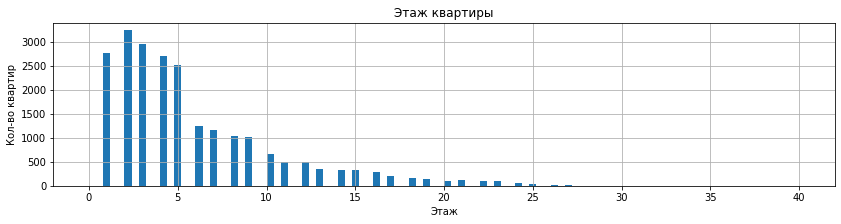

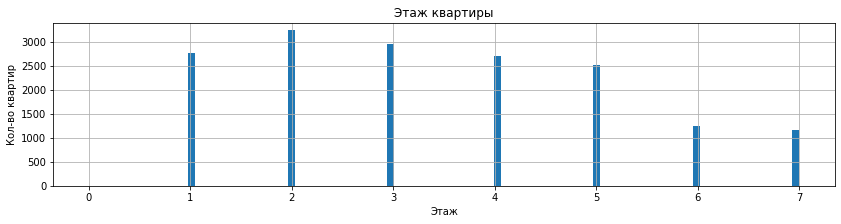

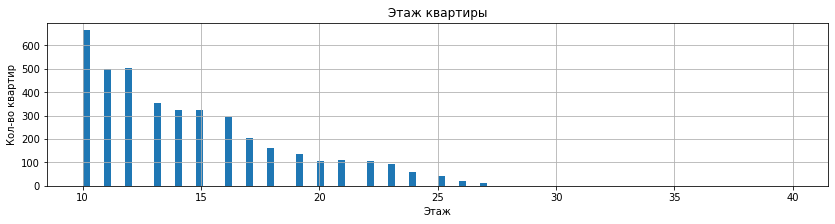

In [157]:
#Посмотрим этажи квартир
print(data['floor'].describe())
print()
print(data['floor'].value_counts())

data.hist('floor', bins=100, figsize=(14, 3), range=(0, 40))
plt.title('Этаж квартиры')
plt.xlabel('Этаж')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('floor', bins=100, figsize=(14, 3), range=(0, 7))
plt.title('Этаж квартиры')
plt.xlabel('Этаж')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('floor', bins=100, figsize=(14, 3), range=(10, 40))
plt.title('Этаж квартиры')
plt.xlabel('Этаж')
plt.ylabel('Кол-во квартир')
plt.show()


##### По данной гистограмме видно, что большинство объектов сосредоточено на 2 и 3 этаже. Ещё можно заметить, что 1, 4 и 5 этаж, пользуется практически одинаковой популярностью, хотя как правило люди при покупке/аренде квартиры редко выбираю первый этаж(возможно в целях безопасности). От 10-го и выше этаж идёт на спад, чем выше этаж, тем меньше объектов.

### Тип этажа квартиры («первый», «последний», «другой»)

In [158]:
#Посмотрим тип этажа квартиры
print(data['floor_type'].value_counts())
print()

#Так как у нас в столбце data['floor_type'] тип данных 'строка', то создадим новый столбец с числовыми значениями
#соответствующими строковым значениям. Другой=2, Последний=3, Первый=1.

def floor_type(row):
    if row['floor'] == 1:
        return 1
    elif row['floor'] == row['floors_total']:
        return 3
    else:
        return 2
    
data['floor_type_info'] = data.apply(floor_type, axis=1)

#Проверим
print(data['floor_type_info'].value_counts())


#data_1 = data.pivot_table(index='floor_type', values='floor', aggfunc='count').plot(kind='bar', grid=True, figsize=(14, 3))


Другой       16708
Последний     3187
Первый        2776
Name: floor_type, dtype: int64

2    16708
3     3187
1     2776
Name: floor_type_info, dtype: int64


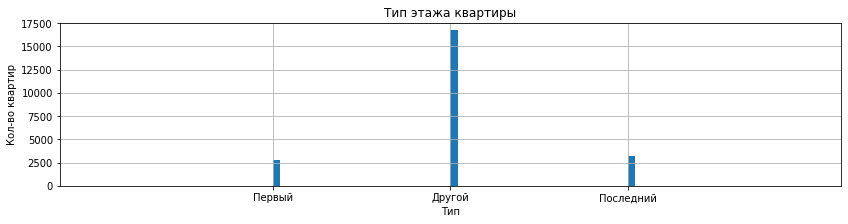

In [159]:
#Теперь построим гистограмму
data.hist('floor_type_info', bins=100, figsize=(14, 3), range=(0, 4))
plt.title('Тип этажа квартиры')
plt.xlabel('Тип')
plt.ylabel('Кол-во квартир')
#Тут 'plt.xticks' заменим подписи с цифр на слова
plt.xticks([1,2,3], ['Первый', 'Другой', 'Последний'])
plt.show()




##### Тут можем увидеть интересную особенность, если разделить объекты на 3-и группы, то получается больше всего квартир продаётся, так сказать, на средних этажах. На первом и последнем меньше всего объявлений.

### Общее количество этажей в доме

count   22,671.00
mean        10.65
std          6.56
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

5     5589
9     3640
16    1333
12    1328
10    1157
4     1156
25    1023
6      856
17     805
3      629
7      564
14     531
18     474
24     433
8      371
15     349
2      343
23     334
19     309
22     271
20     258
13     228
11     199
27     154
21     144
26     120
1       23
35      22
28      21
36       3
52       1
33       1
60       1
29       1
Name: floors_total, dtype: int64



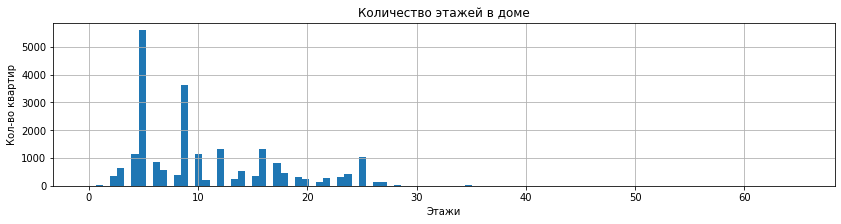

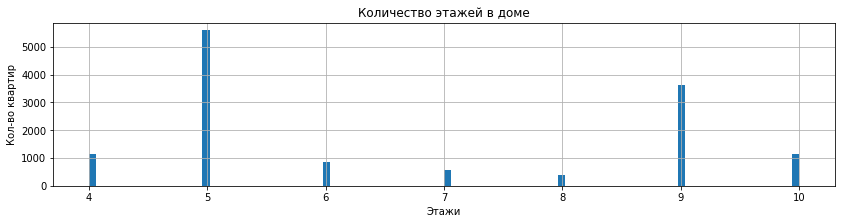

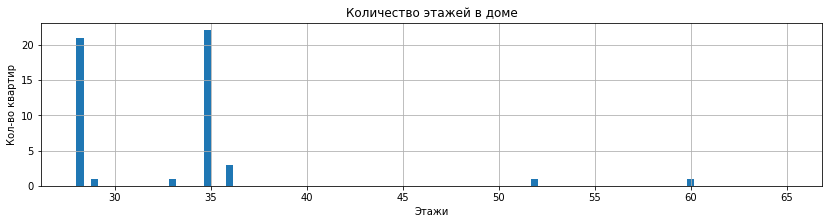

In [160]:
#Посмотрим общее количество этажей
print(data['floors_total'].describe())
print()
#Можно сгруппировать этажи по порядку и посмотреть как обхъекты распределются в зависимости от этажа.
#Но тут данны метод не очень удобно анализировать
#print(data.groupby('floors_total')['floors_total'].count())

#Так будет удобнее
print(data['floors_total'].value_counts())
print()

data.hist('floors_total', bins=100, figsize=(14, 3), range=(0, 65))
plt.title('Количество этажей в доме')
plt.xlabel('Этажи')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('floors_total', bins=100, figsize=(14, 3), range=(4, 10))
plt.title('Количество этажей в доме')
plt.xlabel('Этажи')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('floors_total', bins=100, figsize=(14, 3), range=(28, 65))
plt.title('Количество этажей в доме')
plt.xlabel('Этажи')
plt.ylabel('Кол-во квартир')
plt.show()






##### Интересно, что большая часть объявлений в домах в которых 5 и 9 этажей. В остальном распределение идёт плавно. Ещё можно заметить, что кол-во объектов этажность которых начинается от 28 этажей и выше, не так много. Вероятно дома со средней этажностью пользуются большей поппулярностью.

### Расстояние до центра города в метрах

count   17,471.00
mean    14,232.44
std      8,603.34
min        181.00
25%      9,289.00
50%     13,119.00
75%     16,293.50
max     65,968.00
Name: city_centers_nearest, dtype: float64



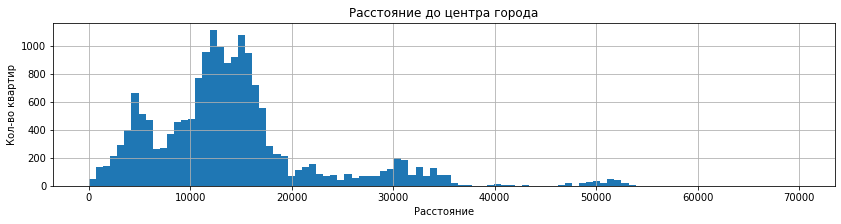

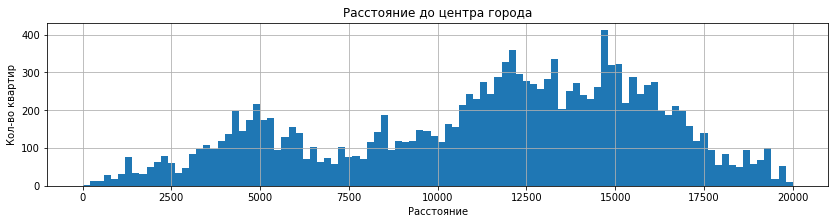

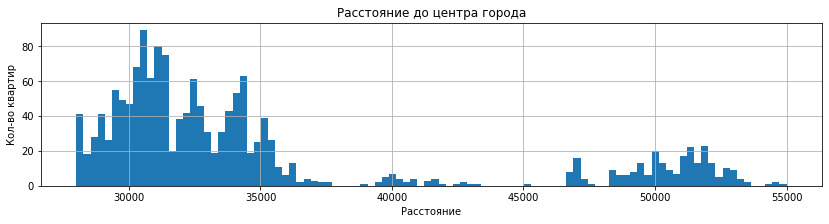

In [161]:
#Посмотрим расстояние до центра города
print(data['city_centers_nearest'].describe())
print()

data.hist('city_centers_nearest', bins=100, figsize=(14, 3), range=(0, 70000))
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('city_centers_nearest', bins=100, figsize=(14, 3), range=(0, 20000))
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('city_centers_nearest', bins=100, figsize=(14, 3), range=(28000, 55000))
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во квартир')
plt.show()


##### 

##### По данной гистограмме видим несколько пиков. Первый и самый выделяющийся находится в диапазоне значений от 10 до 17.5 км, второй пик на отметке 5 км, затем два последних и менее выделяющихся пика на отметке 30 и 50 км.

### Расстояние до ближайшего аэропорта

count   17,451.00
mean    28,888.80
std     12,644.77
min          0.00
25%     18,596.00
50%     26,877.00
75%     37,406.00
max     84,869.00
Name: airports_nearest, dtype: float64



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cena_1м,day_exp,month_exp,year_exp,floor_type,km_do_centra,floor_type_info
21085,0,7000000,34.70,2018-09-23,1,2.70,9,19.80,3,False,False,False,6.00,2,санкт-петербург,0.00,"22,801.00",0.00,NaN,0.00,NaN,60.00,201729,6,9,2018,Другой,23.00,2


count   17,450.00
mean    28,890.46
std     12,643.24
min      6,450.00
25%     18,597.75
50%     26,878.50
75%     37,406.00
max     84,869.00
Name: airports_nearest, dtype: float64


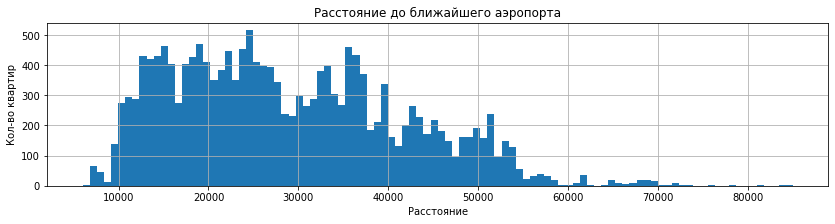

In [162]:
#Посмотрим расстояние до ближайшего аэропорта
print(data['airports_nearest'].describe())
print()

#Удалил данную строку с расстоянием до аэропорта 0 км.
display(data.query('airports_nearest == 0'))
data = data.query('airports_nearest != 0')
print(data['airports_nearest'].describe())

data.hist('airports_nearest', bins=100, figsize=(14, 3), range=(6000, 85000))
plt.title('Расстояние до ближайшего аэропорта')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во квартир')
plt.show()





##### По числовой характеристике был один объект с расстоянием до аэропорта 0 км. Удалил данную строку. Данная гистограмма выглядит равномерно, так как в каждом городе расстояние до аэропорта разное.

### Расстояние до ближайшего парка

count   7,762.00
mean      491.17
std       343.26
min         1.00
25%       288.00
50%       454.00
75%       612.75
max     3,190.00
Name: parks_nearest, dtype: float64



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cena_1м,day_exp,month_exp,year_exp,floor_type,km_do_centra,floor_type_info
14624,8,3770000,45.40,2019-03-20,2,2.70,9,28.43,2,False,False,False,6.90,0,санкт-петербург,"43,932.00","16,436.00",1.00,1.00,0.00,NaN,42.00,83039,2,3,2019,Другой,16.00,2



count   7,762.00
mean      491.17
std       343.26
min         3.00
25%       288.00
50%       454.00
75%       612.75
max     3,190.00
Name: parks_nearest, dtype: float64


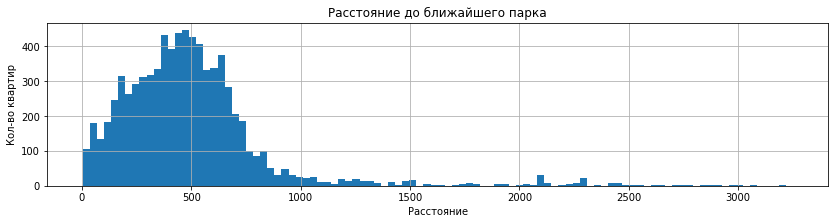

In [163]:
# Посмотрим расстояние до ближайшего парка
print(data['parks_nearest'].describe())
print()

#Домножу строку где расстояние до парка 1м на 10.
display(data.query('parks_nearest <= 1'))
data.loc[data['parks_nearest'] <= 1, 'parks_nearest'] = data.loc[data['parks_nearest'] <= 1, 'parks_nearest'] * 10
print()

#Проверим, теперь минимальное расстояние до парка 3 м, ну это более менее.
print(data['parks_nearest'].describe())

data.hist('parks_nearest', bins=100, figsize=(14, 3), range=(3, 3250))
plt.title('Расстояние до ближайшего парка')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во квартир')
plt.show()

##### По числовой характеристике был один объект с расстоянием до парка 1 м, возможно пропустили один 0. Таких строк всего одна, не стану удалять(это легче всего), а просто домножу это значение на 10. На данной гистограмме объекты  по расстоянию до ближайшего парка находятся в основном в диапазоне от 3 до 1000 метров. В целом тут тоже всё нормально, так как парков в разных городах может быт много и они все на разных расстояниях.


### День и месяц публикации объявления


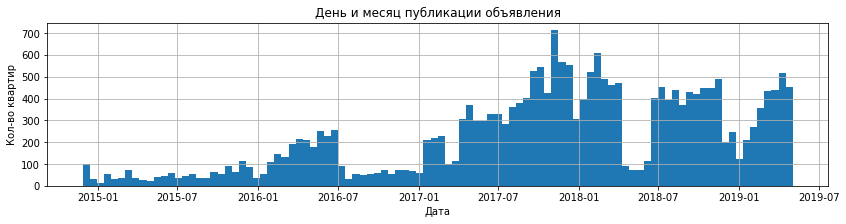

In [164]:
# Посмотрим день и месяц публикации объявления
#'first_day_exposition'

data.hist('first_day_exposition', bins=100, figsize=(14, 3))
plt.title('День и месяц публикации объявления')
plt.xlabel('Дата')
plt.ylabel('Кол-во квартир')
plt.show()



##### По данной гистограмме заметно, что с 2016 года количество обявлений с недвижимостью начало расти. Пик размещения обявлений с недвижимостью пришёлся к концу 2017 и начало 2018 годов. Ещё можно заметить, что активно объявления о недвижимости размещаются в начале года. а именно с первого по седьмой месяцы. Это заметно в 2016, 2017, 2018 и 2019 годах.

### 2. Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 

count   19,618.00
mean       181.49
std        219.77
min          1.00
25%         45.00
50%         96.00
75%        232.00
max      1,580.00
Name: days_exposition, dtype: float64



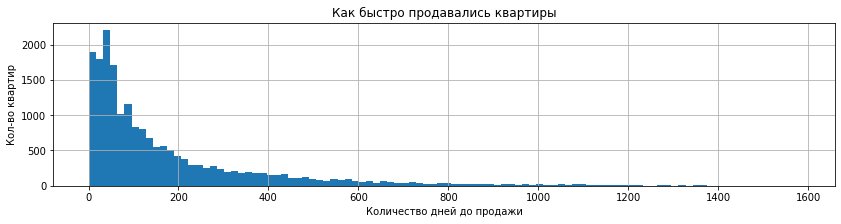

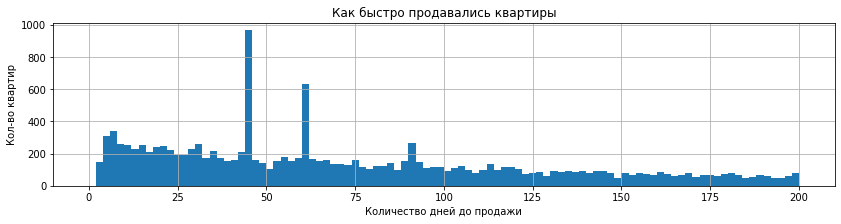

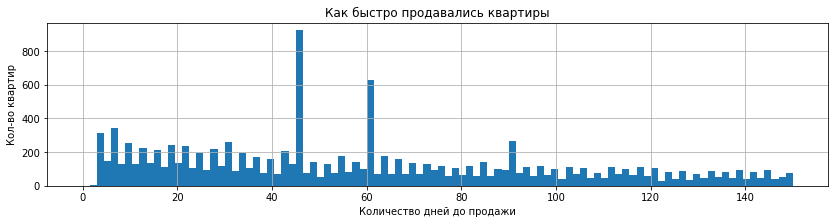

Среднее время продажи: 181.0
Медианное время продажи: 96.0


Text(0, 0.5, 'Количество дней до продажи')

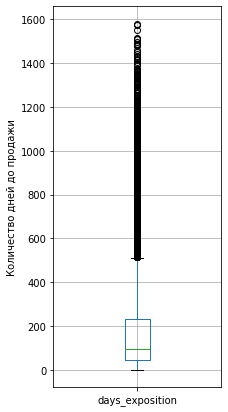

In [165]:
# Посмотрим  как быстро продавались квартиры (столбец days_exposition)
print(data['days_exposition'].describe())
print()
# Построим гистограммы
data.hist('days_exposition', bins=100, figsize=(14, 3))
plt.title('Как быстро продавались квартиры')
plt.xlabel('Количество дней до продажи')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('days_exposition', bins=100, figsize=(14, 3), range=(0, 200))
plt.title('Как быстро продавались квартиры')
plt.xlabel('Количество дней до продажи')
plt.ylabel('Кол-во квартир')
plt.show()

data.hist('days_exposition', bins=100, figsize=(14, 3), range=(0, 150))
plt.title('Как быстро продавались квартиры')
plt.xlabel('Количество дней до продажи')
plt.ylabel('Кол-во квартир')
plt.show()

# Посчитаем среднее и медиану(но выше в самой первой строке этой ячейки методом describe() мы уже посмотрели среднее и медиану)
print('Среднее время продажи:', data['days_exposition'].mean().round(0))
print('Медианное время продажи:', data['days_exposition'].median())

data.boxplot(column='days_exposition', figsize=(3,7))
plt.ylabel('Количество дней до продажи')



##### Считаю, что обычно продажа занимает до 150 дней, это видно по гистограмме, так как там сосредоточен пик. Но среднее значение нам говорит, что это около 181 дня. Я думаю, что брать показатель медианы для определения ''обычного'' времени продажи не совсем правильно, так как на срок продажи объекта влияет очень много разных факторов. Быстыми продажами , думаю можно считать те котороые расположились в районе медианного значения, это около 96 дней + по гистограмме видно, что основная масса всё таки располагается как раз в диапазоне от 1 до 100 дней. Всё что продаётся от 400-500 дней и выше можно считать необычно долгими продажами, об этом говорит диаграмма размаха.



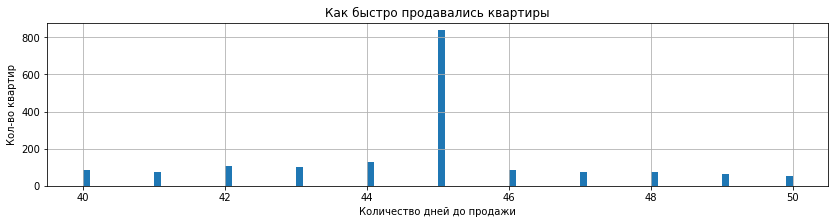

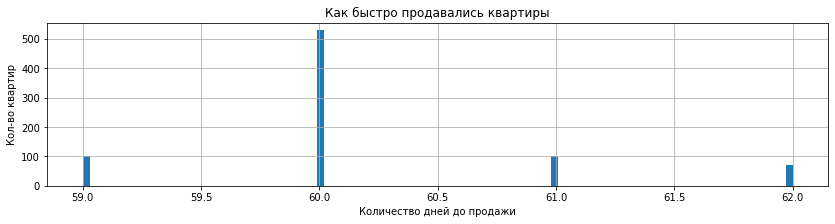

In [166]:
data.hist('days_exposition', bins=100, figsize=(14, 3), range=(40, 50))
plt.title('Как быстро продавались квартиры')
plt.xlabel('Количество дней до продажи')
plt.ylabel('Кол-во квартир')
plt.show()
print()
data.hist('days_exposition', bins=100, figsize=(14, 3), range=(59, 62))
plt.title('Как быстро продавались квартиры')
plt.xlabel('Количество дней до продажи')
plt.ylabel('Кол-во квартир')
plt.show()

### 3. Какие факторы больше всего влияют на общую (полную) стоимость объекта?

### Посмотрим, зависит ли цена от общей площади:

Корелляция цены от общей площади: 0.75 %



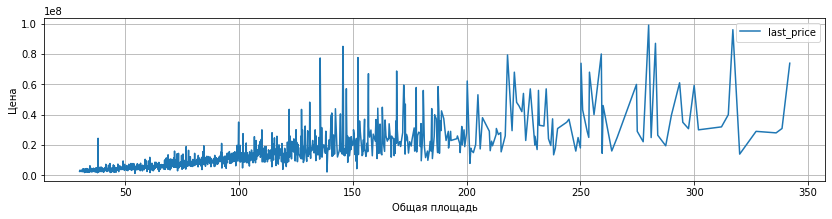

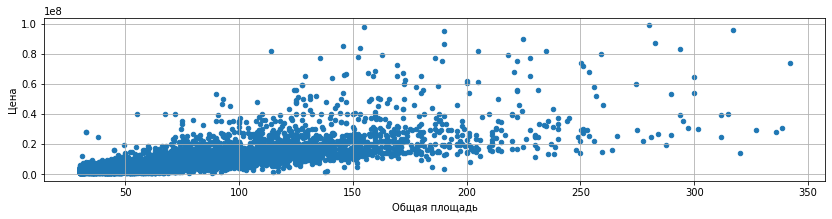

In [180]:
print('Корелляция цены от общей площади:', data['last_price'].corr(data['total_area']).round(2), '%')
data.pivot_table(index='total_area', values='last_price').plot(grid=True, figsize=(14, 3))
plt.ylabel('Цена')
plt.xlabel('Общая площадь');
print()
data.plot(y='last_price', x='total_area', grid=True, figsize=(14, 3), kind='scatter')
plt.ylabel('Цена')
plt.xlabel('Общая площадь')
plt.show()

##### По графику видно, что в зависимости от площади возрастает и цена объекта, что логично.

### Посмотрим, зависит ли цена от жилой площади:

Корреляция цены от жилой площади: 0.63 %


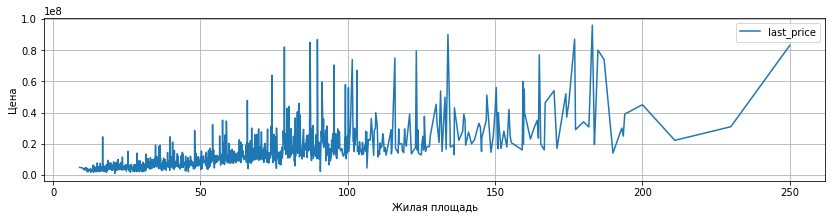

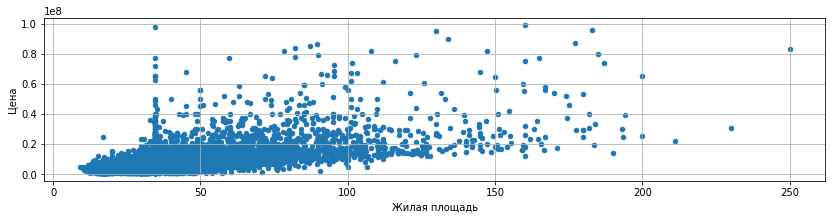

In [182]:
print('Корреляция цены от жилой площади:', data['last_price'].corr(data['living_area']).round(2), '%')
data.pivot_table(index='living_area', values='last_price').plot(grid=True, figsize=(14, 3))
plt.ylabel('Цена')
plt.xlabel('Жилая площадь');
data.plot(y='last_price', x='living_area', grid=True, figsize=(14, 3), kind='scatter')
plt.ylabel('Цена')
plt.xlabel('Жилая площадь')
plt.show()

##### По графику видно, что зависимость есть, но она заметно снизилась по сравнению к примеру с показателями, что представлены выше.

### Посмотрим, зависит ли цена от площади кухни:

Корреляция цены от площади кухни: 0.54 %


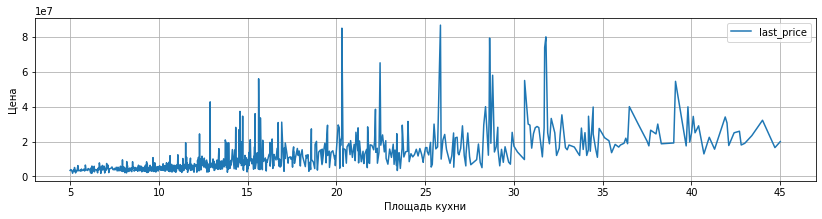

In [169]:
print('Корреляция цены от площади кухни:', data['last_price'].corr(data['kitchen_area']).round(2), '%')
data.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, figsize=(14, 3))
plt.ylabel('Цена')
plt.xlabel('Площадь кухни');

##### График говорит о том, что зависимость цены от площади кухни снижается ещё больше.

### Посмотрим, зависит ли цена от количества комнат:

Корреляция цены от количества комнат: 0.45 %


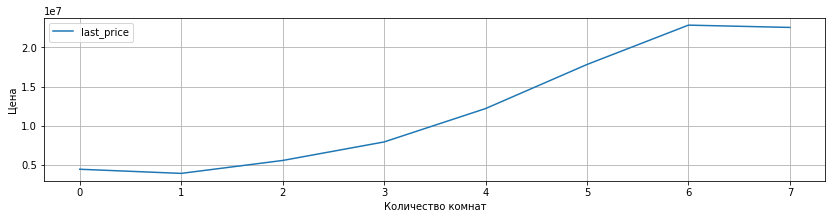

In [170]:
print('Корреляция цены от количества комнат:', data['last_price'].corr(data['rooms']).round(2), '%')
data.pivot_table(index='rooms', values='last_price').plot(grid=True, figsize=(14, 3))
plt.ylabel('Цена')
plt.xlabel('Количество комнат');

##### Тут можно заметить, что от 0 комнат(это студии) до 1 комнаты цена почти не меняется, далее начиная от 2-х комнат и до 6-и видно, что есть зависимость. От 6-и и до 7-ми комнат цена практически одинаковая.В целом с увеличением комнат, увеличивается цена объекта. Тут так же как и в примере с площадью. Логично что чем больше комнат, тем больше площадь, а значит и цена выше.

### Посмотрим, зависит ли цена от этажа, на котором расположена квартира (первый, последний, другой):

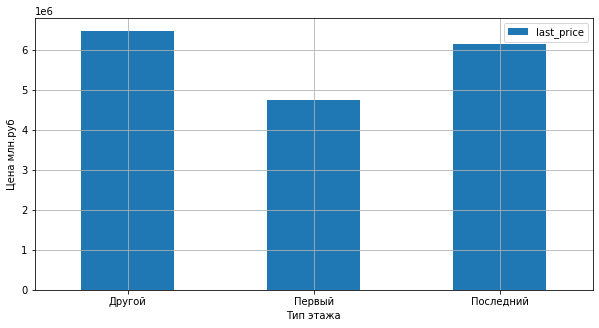

In [171]:
data.pivot_table(index='floor_type', values='last_price').plot(grid=True, figsize=(10, 5), kind='bar')
plt.ylabel('Цена млн.руб')
plt.xlabel('Тип этажа');
#Этот код переворачивает подписи столбцов горизонтально
plt.xticks(rotation=0);

##### Зависимость цены от этажа прослеживается. Первый этаж любят меньше всего, следовательно и цена самая низкая по сравнению с другими. Самый большой спрос на этажи котрые расположены не на первом и не на последнем, следовательно и цена будет выше.

### Посмотрим, зависит ли цена от даты размещения (день недели, месяц, год):

#### День недели

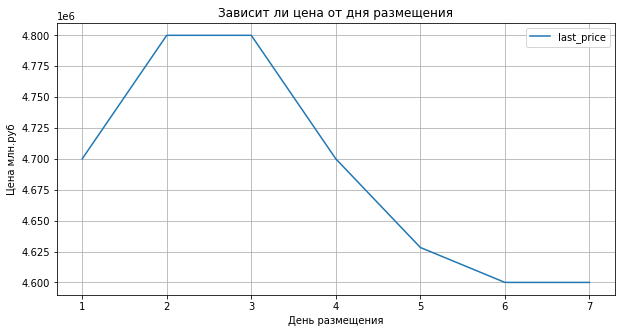

In [172]:
data.pivot_table(index='day_exp', values='last_price', aggfunc='median').plot(grid=True, figsize=(10, 5) \
,title='Зависит ли цена от дня размещения')
plt.ylabel('Цена млн.руб')
plt.xlabel('День размещения')
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])
plt.xticks(rotation=0)
plt.show()

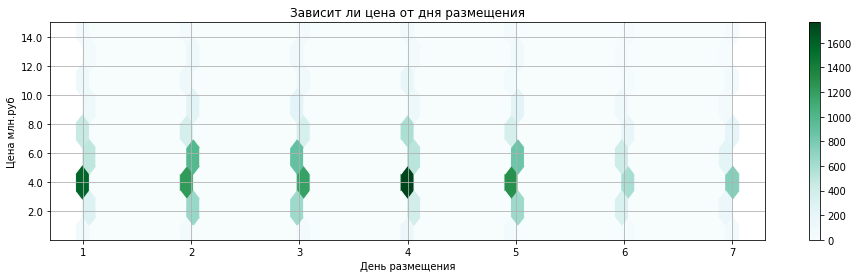

In [173]:
# Данный график показывает количество объявлений, сделлых в опредеоленный период времени
data.plot(x='day_exp', y='last_price', kind='hexbin', gridsize=50, sharex=False, grid=True, figsize=(16,4),ylim=(0,15000000)\
,title='Зависит ли цена от дня размещения')
plt.ylabel('Цена млн.руб')
plt.xlabel('День размещения')
plt.yticks([2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000], [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])
plt.show()

#### Месяц

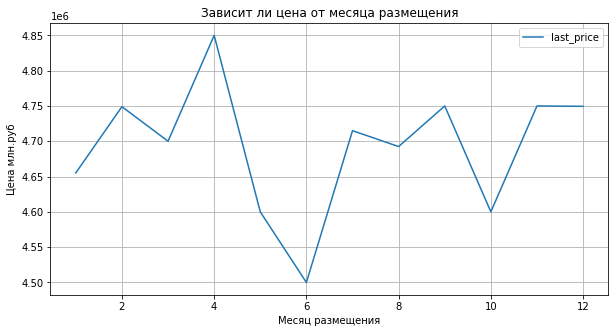

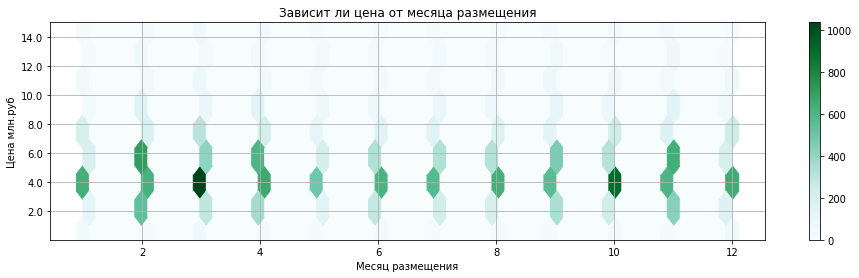

In [174]:
data.pivot_table(index='month_exp', values='last_price', aggfunc='median').plot(grid=True, figsize=(10, 5) \
,title='Зависит ли цена от месяца размещения')
plt.ylabel('Цена млн.руб')
plt.xlabel('Месяц размещения')
plt.xticks(rotation=0);
print()
data.plot(x='month_exp', y='last_price', kind='hexbin', gridsize=50, sharex=False, grid=True, figsize=(16,4),ylim=(0,15000000)\
,title='Зависит ли цена от месяца размещения')
plt.ylabel('Цена млн.руб')
plt.xlabel('Месяц размещения')
plt.yticks([2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000], [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0]);

#### Год

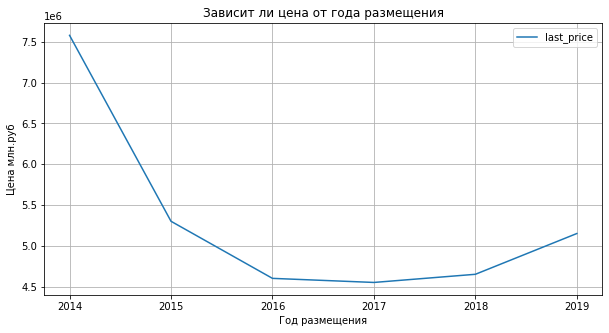

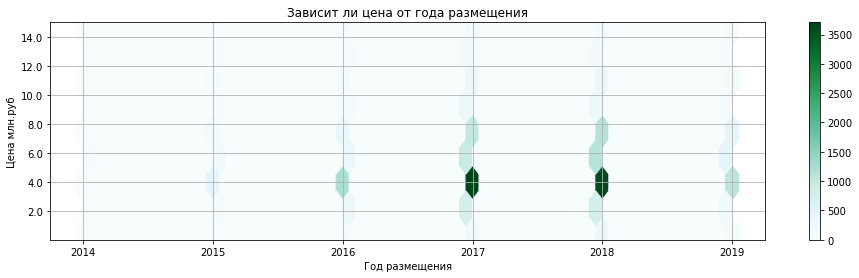

In [175]:
data.pivot_table(index='year_exp', values='last_price', aggfunc='median').plot(grid=True, figsize=(10, 5) \
,title='Зависит ли цена от года размещения')
plt.ylabel('Цена млн.руб')
plt.xlabel('Год размещения')
plt.xticks(rotation=0);
print()
data.plot(x='year_exp', y='last_price', kind='hexbin', gridsize=50, sharex=False, grid=True, figsize=(16,4),ylim=(0,15000000)\
,title='Зависит ли цена от года размещения')
plt.ylabel('Цена млн.руб')
plt.xlabel('Год размещения')
plt.yticks([2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000], [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0]);

##### Вывод: в первую очередь на полную стоимость объекта недвижимости влияет общая площадь и количество комнат, зависимость прямопропорциональная, чем больше общая площадь и кол-во комнат, тем выше цена. На втором месте на цену оказывает влияние жилая площадь и площадь кухни. Ещё один не маловажный фактор, который оказывает влияние на цену - это этаж на котором располагается объект. Люди больше предпочитают какой-то средний этаж, но никак не первый и не последний. 

##### Дата размещения: дороже всего квартиры, объявления о которых были размещены со вторника по среду, а дешевле всего квартиры опубликованные с субботы по воскресение. Так же есть зависимость, в начале года первые 3-и месяца идёт рост цен на недвижимомть, далее идёт спад и начиная с лета цена на недвижимость вновь начинает расти. Можно сказать что рост цен на недвижимость имеет сезонный характер. По году интересные наблюдения. С 2014 по 2017 идёт спад на цены, а начиная с 2017 цены постепенно начинают возрастать. Возможно тут есть какая-то связь с экономическими событиями.

##### Ещё я заметил, что на количество объявлений влияет временной период в который размещается объявление.
День недели: больше всего объявлений размещают в понедельник и четверг.

Месяц: больше всего объявлений размещают в начале года с января по апрель и в конце года с октября по декабрь.

Год: больше всего объявлений было размещено в 2017 и 2018 годах.

### 4. Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [176]:
#Тут в aggfunc я применяю count для того чтобы посчитались кол-ва объявлений в каждом городе
goroda_10 = data.pivot_table(index = 'locality_name', values = 'cena_1м', aggfunc = ['count', 'mean'])
print('Было:')
print(goroda_10)
print()

#Тут я меняю названия колонок count cena_1м == obyavleniya и mean cena_1м == cena_1м(остаётся без изменения, но указывается, т.к.
#список должен иметь столько же элементов, сколько столбцов в датафрейме
goroda_10.columns = ['obyavleniya', 'cena_1м']
goroda_10 = goroda_10.sort_values(by='obyavleniya', ascending=False).head(10)
goroda_10.reset_index(inplace=True)



print('Стало:')
print(goroda_10)
print()

print('Населённые пункты с самой низкой стоимостью квадратного метра:')
print(goroda_10.loc[goroda_10['cena_1м']==goroda_10['cena_1м'].min()])
print()
print('Населённые пункты с самой высокой стоимостью квадратного метра:')
print(goroda_10.loc[goroda_10['cena_1м']==goroda_10['cena_1м'].max()])


#Можно вот так ещё было сделать
#goroda_10 = data.groupby('locality_name')['cena_1м'].agg(['count', 'mean']).sort_values(by='count', ascending=False).head(10)
#goroda_10.columns = ['obyavleniya', 'cena_1м']
#goroda_10.reset_index(inplace=True)
#print(goroda_10)

Было:
                count      mean
              cena_1м   cena_1м
locality_name                  
unknowm            47 95,208.79
бокситогорск       15 17,456.80
волосово           36 40,182.89
волхов            104 35,063.63
всеволожск        386 68,636.14
...               ...       ...
сосновый бор       84 74,927.20
сясьстрой          23 34,485.35
тихвин             48 39,991.42
тосно             101 58,592.75
шлиссельбург       57 58,583.67

[318 rows x 2 columns]

Стало:
       locality_name  obyavleniya    cena_1м
0    санкт-петербург        15081 112,988.85
1     поселок мурино          477  84,247.10
2     поселок шушары          423  77,752.47
3         всеволожск          386  68,636.14
4             пушкин          358 103,089.86
5            колпино          331  75,176.18
6  поселок парголово          321  90,080.37
7            гатчина          299  68,889.82
8    деревня кудрово          268  91,803.24
9             выборг          222  57,990.20

Населённые пункты 

### 5. Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города.

In [177]:
#Это чтобы миллионы было удобно читать. Числа выходят с разделителями.
pd.options.display.float_format = '{:,.2f}'.format

#Вывел таблицу, чтобы посмотреть глазами на цифры и увидеть, сколько объявлений в каждом районе.
cena_za_km = data.query('locality_name == "санкт-петербург"') \
.pivot_table(index='km_do_centra', values='last_price', aggfunc=['count', 'mean'])

#Тут я меняю названия колонок count last_price == obyavleniya и mean last_price == last_price (остаётся без изменения, но указывается, т.к.
#список должен иметь столько же элементов, сколько столбцов в датафрейме
cena_za_km.columns = ['obyavleniya', 'last_price']
cena_za_km

,obyavleniya,last_price
km_do_centra,,
0.00,21,"22,989,601.33"
1.00,179,"15,906,268.16"
2.00,286,"14,448,063.22"
3.00,336,"10,892,227.24"
4.00,657,"11,306,392.58"
5.00,869,"12,069,757.18"
6.00,588,"13,132,636.54"
7.00,404,"13,843,360.79"
8.00,573,"9,189,942.69"


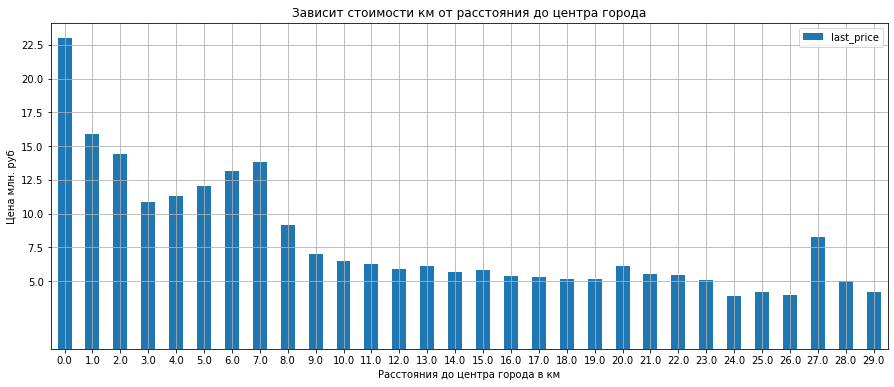

In [178]:
#Построим график
cena_za_km = data.query('locality_name == "санкт-петербург"') \
.pivot_table(index='km_do_centra', values='last_price', aggfunc='mean').plot(grid=True, figsize=(15, 6), kind='bar')
plt.title('Зависит стоимости км от расстояния до центра города')
plt.ylabel('Цена млн. руб')
plt.xlabel('Расстояния до центра города в км')
plt.yticks([5000000, 7500000, 10000000, 12500000, 15000000, 17500000, 20000000, 22500000], [5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5])
#Этот код переворачивает подписи столбцов горизонтально
plt.xticks(rotation=0);
plt.show()

##### Вывод: по графику видно, что пик цен приходится на квартиры на расстоянии до 1 км (в данном случае 0 км), затем после 1 км начинается плавный спад, но цены держутся в диапазоне от чуть более 10 млн и до 15 с небольшим млн.. Начиная с 7-го км от центра цены начинают снижаться сильнее и держаться в диапазоне примерно 9 млн - 4 млн. В итоге самые дорогие квартиры находятся до 7-ми км от центра включительно.

### Шаг 5. Общий вывод
1) Для анализа была дана таблица с информацией по продаже квартир. Таблица состоял из 22 колонок и 23699 строк. 7 колонок не пригодились (total_images, open_plan, balcony, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest). В качестве разделителя в csv файле использовался знак табуляции (\t), вместо типичной точки с запятой. Было замечено, что в одной из колонок 'cityCenters_nearest' имелось не корректное название (изменили на этапе предобработки на city_centers_nearest).

2) В процессе предобработки удалили 4,33%(1028 строк), cчитаю значение вполне допустимым.

В стлобце ceiling_height пропуски заменены медианными значениями, а так же исправлены ошибочно введенные значения, в которых справа присутствовал лишний ноль.

Столбец first_day_exposition привели к корректному типу datetime64.

В столбцах living_area и kitchen_area пропуски заменены средними значениями в зависимости от отношения к общей площади. Ещё в столбце площадь кухни(kitchen_area) были обнаружены значения превышающие значения жилой площади(living_area). Поменяли их местами, считаю тем самым сохранили какую-то часть данных, вместо того чтобы их удалять.

В числовых столбцах заменены типы на int, кроме столбцов с площадями.

В столбце days_exposition пропуски не заполнял(подробный комментарий указан выше, в разделе который относится к работе с этим столбцом).

Обрезаны сильные выбросы в столбцах где они были (kitchen_area, last_price, total_area, rooms, ceiling_height, living_area, kitchen_area).

В столбцах с расстояниями (airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest) пропуски не заменял(подробный комментарий указан выше, в разделе который относится к работе с этим столбцом).

Количество уникальных занчений locality_name сократили на 41, было 364, стало 323.

Было добавлено 7 столбцов, в которых были подсчитаны дополнительные параметры:
цена квадратного метра;
день недели, месяц и год публикации объявления;
этаж квартиры; варианты — первый, последний, другой;
расстояние до центра в км;
тип этажа первый последний другой.

3)Был проведен анализ и сделаны выводы по заданым вопросам:
Основная масса квартир с площадями от 30м² до 45м² и вероятнее всего это однокомнатные квартиры. Далее идут 2-ки, 3-ки. в диапазоне от 45м² и 75-80м². После скорее всего идут 4-х комнатные и более. Видно, что с увеличенем площади уменьшается количество квартир.
Основная масса квартир с жилой площадью сосредоточена в районе 18м², 30м² и 34м².
Диапазон площади кухни распределился в основном от 5м² до 15м², а в среднем 10м².
В основном квартиры продаются от 2,5 млн до примерно 5,5 млн. Далее же с увеличением числа стоимости объекта, уменьшается кол-во таких объектов.
По кол-ву комнат в основном преобладают 1-ки и 2-ки. Трёхкомнатные тоже предпочитают, вероятнее всего люди у которых большая семья. С 4-х комнатными тоже самое, но их очень мало, как и квартир в которых комнат от 4-х и выше.
По высоте потолков можно сказать, что есть как минимальные значения 2.30м(возможно это какие не супер новые дома) так и немного выбивающиеся из нормы от 2.75м до 3м(можно предположить, что это объекты с индивидуальной планировкой или что-то подобное). Больше всего преобладают, конечно же, стандартные варианты от 2.5м до 2.75м.
Что касается этажей, то тут большинство объектов сосредоточено на 2 и 3 этаже. Ещё можно заметить, что 1, 4 и 5 этаж, пользуется практически одинаковой популярностью, хотя как правило люди при покупке/аренде квартиры редко выбираю первый этаж(возможно в целях безопасности).
Было выявлено, что больше всего квартир продаётся на средних этажах. На первом и последнем меньше всего объявлений.
Большая часть объявлений в домах в которых 5 и 9 этажей.
Расстояние до центра распределилось следующим образом, первыми идут объявления в диапазоне значений от 10 до 17.5 км, далее на отметке 5 км, затем 30 и 50 км.
Расстояние до ближайшего аэропорта в среднем составляет 28км.
Объекты по расстоянию до ближайшего парка находятся в основном в диапазоне от 3 до 1000 метров.
День и месяц публикации объявлений распределились следующим образом. с 2016 года количество обявлений с недвижимостью начало расти. Пик размещения обявлений с недвижимостью пришёлся к концу 2017 и начало 2018 годов. Ещё можно заметить, что активно объявления о недвижимости размещаются в начале года, а именно с первого по седьмой месяцы. 

Так же было изучено как быстро продавались квартиры. Получил следующую информацию. Обычно продажа занимает до 150 дней. Быстыми продажами , думаю можно считать те котороые расположились в районе медианного значения, это около 96 дней. Всё что продаётся от 400-500 дней и выше можно считать необычно долгими продажами.

4)Факторы больше всего влияют на общую (полную) стоимость объекта следующие. В первую очередь на полную стоимость объекта недвижимости влияет общая площадь и количество комнат, зависимость прямопропорциональная, чем больше общая площадь и кол-во комнат, тем выше цена. На втором месте на цену оказывает влияние жилая площадь и площадь кухни. Ещё один не маловажный фактор, который оказывает влияние на цену - это этаж на котором располагается объект. Люди больше предпочитают какой-то средний этаж, но никак не первый и не последний.

По дате размещения объявлений так же имеются интересные наблюдения. Дороже всего квартиры, объявления о которых были размещены со вторника по среду, а дешевле всего квартиры опубликованные с субботы по воскресение. Так же есть зависимость, в начале года первые 3-и месяца идёт рост цен на недвижимомть, далее идёт спад и начиная с лета цена на недвижимость вновь начинает расти. Можно сказать что рост цен на недвижимость имеет сезонный характер. По году интересные наблюдения. С 2014 по 2017 идёт спад на цены, а начиная с 2017 цены постепенно начинают возрастать. Возможно тут есть какая-то связь с экономическими событиями.

Дополнительно было выявлено, что на количество объявлений влияет временной период в который размещается объявление.

День недели: больше всего объявлений размещают в понедельник и четверг.

Месяц: больше всего объявлений размещают в начале года с января по апрель и в конце года с октября по декабрь.

Год: больше всего объявлений было размещено в 2017 и 2018 годах.

Подавляющее большинство квартир продается в Санкт-Петербурге - 15081, а цена около 112,988.85 рублей за квдратный метр. Помимо Санкт-Петербурга в Топ10 входят: поселок Мурино, поселок Шушары, Всеволожск, Пушкин, Колпино, поселок Парголово, Гатчина, деревня Кудрово, Выборг с ценами от 57,990.20 до 103,089.86 рублей за квдратный метр.

Что касается объявлений в Санкт-Петербурге, то пик цен приходится на квартиры на расстоянии до 1 км (в данном случае 0 км), затем после 1 км начинается плавный спад, но цены держутся в диапазоне от чуть более 10 млн и до 15 с небольшим млн.. Начиная с 7-го км от центра цены начинают снижаться сильнее и держаться в диапазоне примерно 9 млн - 4 млн. В итоге самые дорогие квартиры находятся до 7-ми км от центра включительно.